# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts across multiple years. Workbook data-preparation.ipynb contains all the code.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In the end I decided not to use any indicator.

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

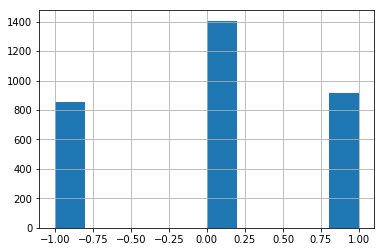

In [12]:
gold['target'].hist()

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

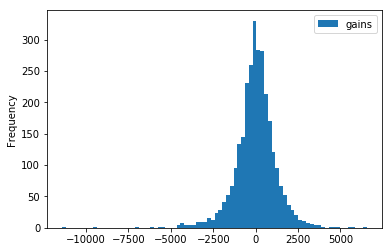

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')

### Investigate suitable stop-loss value

Below are cumulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



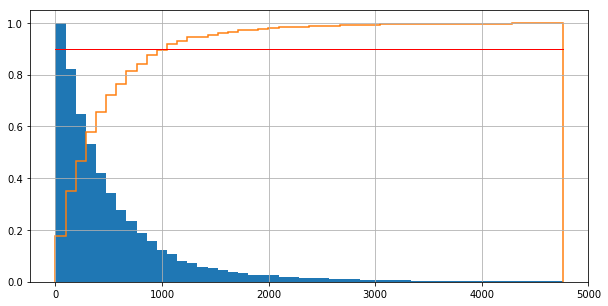

In [18]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

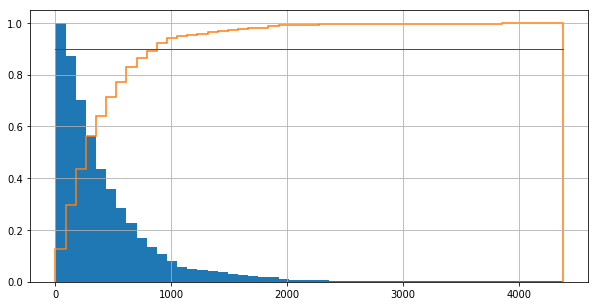

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')

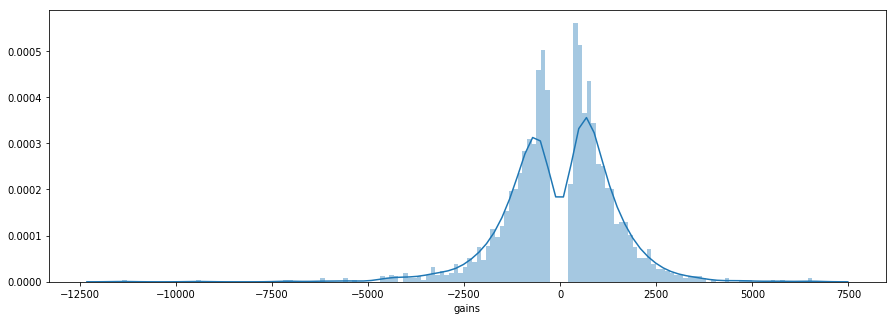

In [22]:
sr = gold_gains_train.loc[gold_gains_train.index < '2018-01-01'][gold_gains_train.gains.abs() > 300].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=150, ax=ax)

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

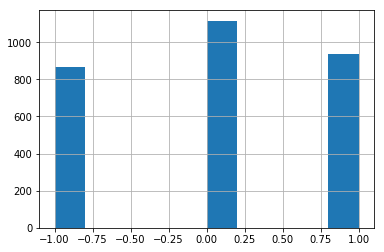

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.loc[corn.index < '2018-1-1'].target.hist()

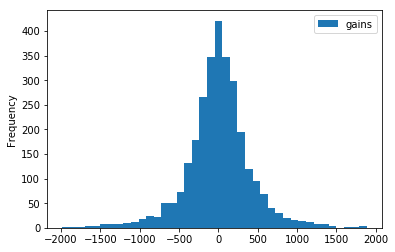

In [26]:
corn_gains_train[['gains']].plot.hist(bins=40)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

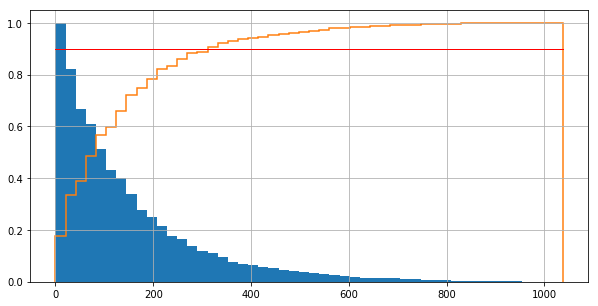

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')

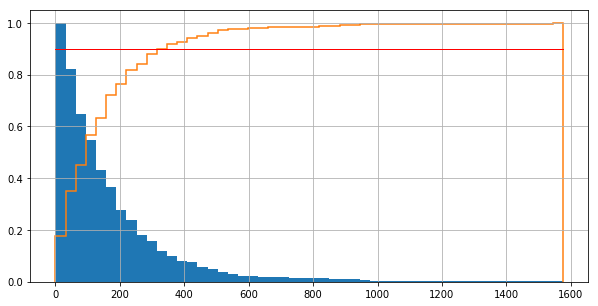

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


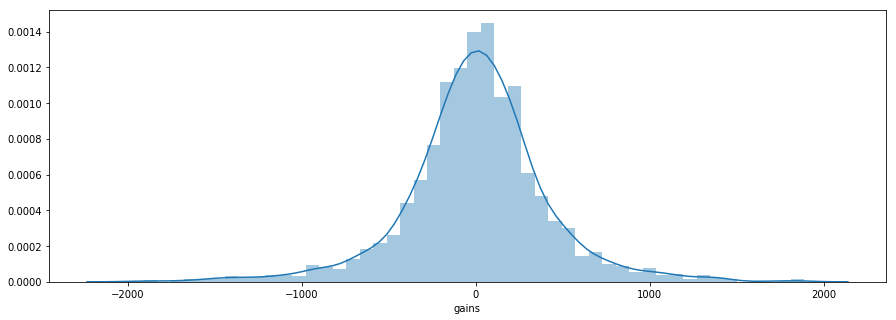

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, ax=ax)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


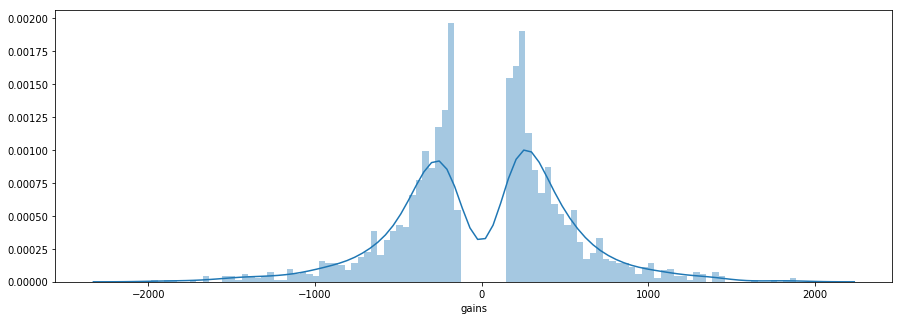

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

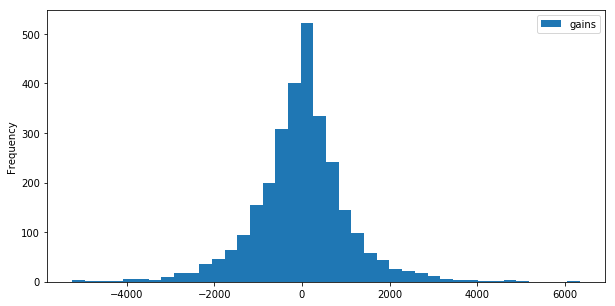

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

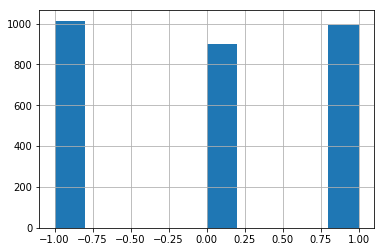

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.loc[coffee.index < '2018-1-1'].target.hist()

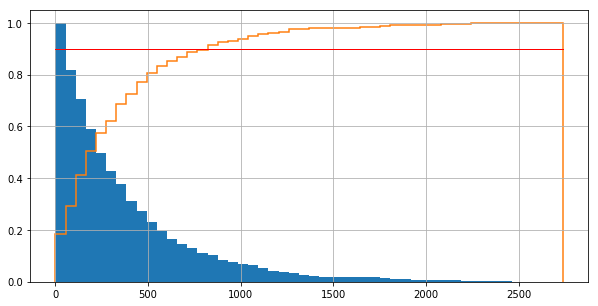

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')

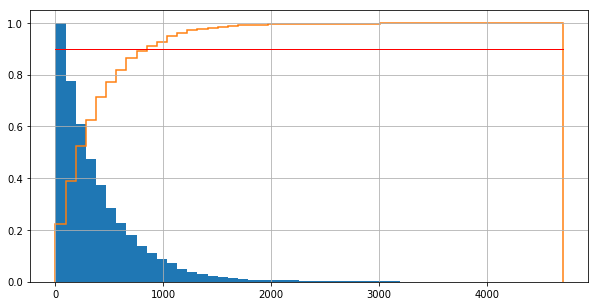

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')

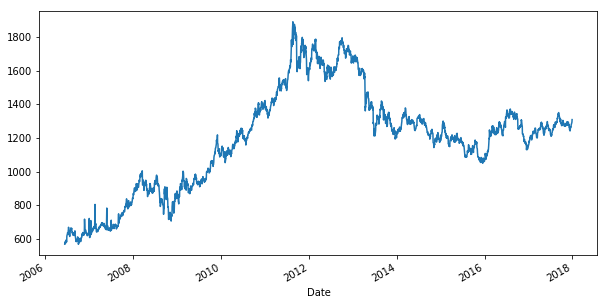

In [39]:
gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(10, 5))

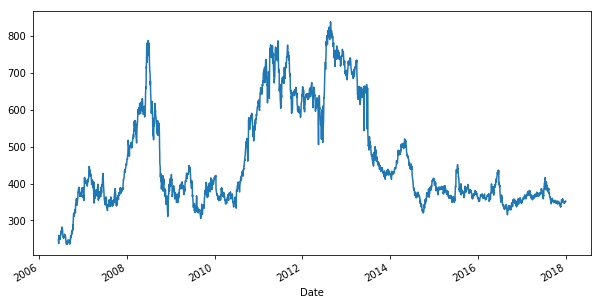

In [40]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

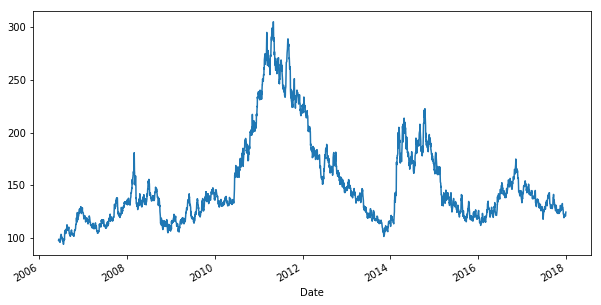

In [41]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

# Feature Engineering

Code below create date features. In order to capture cyclicality I have transformed features as trading day of month or day of week into $sin$ and $cos$ values.
I am not sure whether this transformation grants subsequent PCA usage.

In [42]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [43]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [44]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [45]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


Removing Nan from data

In [46]:
gold_data.shape

(2668, 2545)

In [47]:
gold_data = gold_data.dropna()
gold_data.shape

(2668, 2545)

In [48]:
print(corn_data.shape)
corn_data = corn_data.dropna()
corn_data.shape

(2664, 2545)


(2664, 2545)

In [49]:
print(coffee_data.shape)
coffee_data = coffee_data.dropna()
coffee_data.shape

(2655, 2545)


(2655, 2545)

In [50]:
print(gold_data_reg.shape)
gold_data_reg = gold_data_reg.dropna()
gold_data_reg.shape

(2668, 2545)


(2668, 2545)

In [51]:
print(corn_data_reg.shape)
corn_data_reg = corn_data_reg.dropna()
corn_data_reg.shape

(2664, 2545)


(2664, 2545)

In [52]:
print(coffee_data_reg.shape)
coffee_data_reg = coffee_data_reg.dropna()
coffee_data_reg.shape

(2655, 2545)


(2654, 2545)

In [53]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [54]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [55]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [56]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [57]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new')
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new')
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new')
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [58]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 2
inliers: 1931


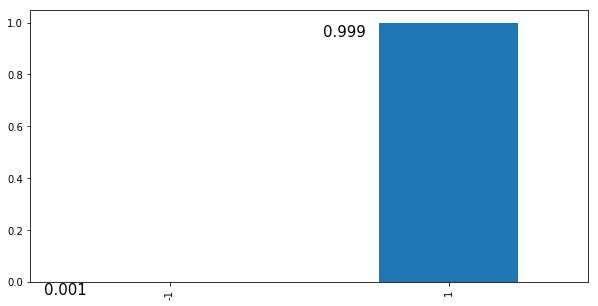

In [59]:
plot_hist_perc(modified_gold)

In [60]:
gold_out = []

for v in pca_gold:
    [p] = out_gold.predict([v])
    if p != 1:
        gold_out.append(v)

In [61]:
gold_out_orig = []

for index, row in gold_train.iterrows():
    [nv] = pca_transform(gold_train.loc[[index]], gold_pca)
    check = [1 for v in gold_out if np.allclose(v, nv)]
    if check:
        print(index)
        gold_out_orig.append(v)

2017-07-21 00:00:00
2017-07-20 00:00:00


outliers: 15
inliers: 1915


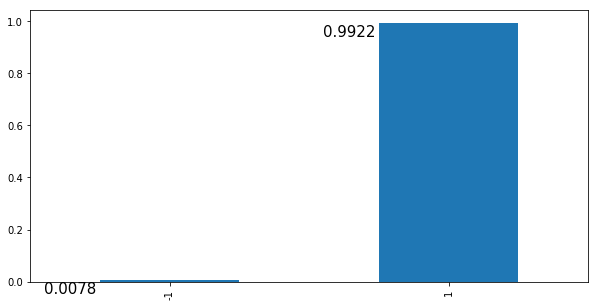

In [62]:
plot_hist_perc(modified_corn)

In [63]:
corn_out = []

for v in pca_corn:
    [p] = out_corn.predict([v])
    if p != 1:
        corn_out.append(v)
        
corn_out_orig = []

for index, row in corn_train.iterrows():
    [nv] = pca_transform(corn_train.loc[[index]], corn_pca)
    check = [1 for v in corn_out if np.allclose(v, nv)]
    if check:
        print(index)
        corn_out_orig.append(v)

2017-10-24 00:00:00
2017-08-29 00:00:00
2017-04-12 00:00:00
2017-06-27 00:00:00
2017-06-14 00:00:00
2017-06-28 00:00:00
2017-11-06 00:00:00
2017-06-20 00:00:00
2017-08-15 00:00:00
2017-09-25 00:00:00
2017-09-26 00:00:00
2017-10-03 00:00:00
2017-12-27 00:00:00
2017-09-13 00:00:00
2017-08-30 00:00:00


Coffee data contains unusually big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 341
inliers: 1582


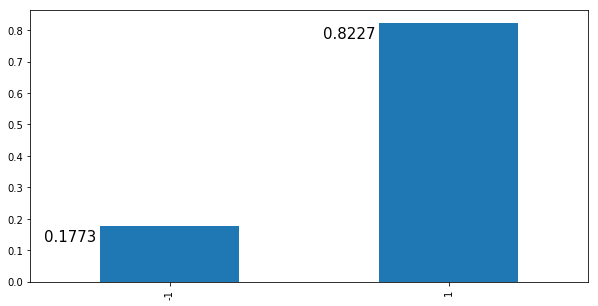

In [64]:
plot_hist_perc(modified_coffee)

In [65]:
coffee_out = []

for v in pca_coffee:
    [p] = out_coffee.predict([v])
    if p != 1:
        coffee_out.append(v)
        
coffee_out_orig = []

for index, row in coffee_train.iterrows():
    [nv] = pca_transform(coffee_train.loc[[index]], coffee_pca)
    check = [1 for v in coffee_out if np.allclose(v, nv)]
    if check:
        print(index)
        coffee_out_orig.append(v)

2008-06-26 00:00:00
2010-01-07 00:00:00
2009-04-06 00:00:00
2008-08-28 00:00:00
2008-07-02 00:00:00
2008-11-25 00:00:00
2008-12-04 00:00:00
2008-09-16 00:00:00
2010-01-28 00:00:00
2009-08-12 00:00:00
2010-01-08 00:00:00
2008-09-15 00:00:00
2009-09-02 00:00:00
2009-02-09 00:00:00
2009-05-29 00:00:00
2009-07-20 00:00:00
2009-09-18 00:00:00
2009-07-08 00:00:00
2009-02-11 00:00:00
2008-11-03 00:00:00
2009-03-10 00:00:00
2009-12-10 00:00:00
2009-02-02 00:00:00
2009-04-01 00:00:00
2008-08-29 00:00:00
2009-02-20 00:00:00
2008-12-01 00:00:00
2008-12-24 00:00:00
2009-08-17 00:00:00
2009-06-25 00:00:00
2009-08-21 00:00:00
2010-03-02 00:00:00
2008-07-18 00:00:00
2009-08-19 00:00:00
2009-11-30 00:00:00
2008-12-19 00:00:00
2009-11-13 00:00:00
2009-09-08 00:00:00
2009-12-14 00:00:00
2009-06-18 00:00:00
2009-04-17 00:00:00
2009-10-23 00:00:00
2009-11-03 00:00:00
2009-01-21 00:00:00
2009-05-28 00:00:00
2009-05-11 00:00:00
2008-12-30 00:00:00
2009-01-28 00:00:00
2008-10-20 00:00:00
2009-06-30 00:00:00


In [66]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = df.loc[df.index < '2018-1-1'][2544].values
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

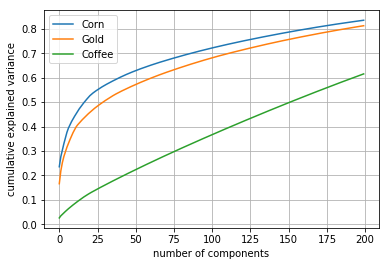

In [67]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
plt.show()

It is interesting Corn is best explained by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that PCA transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components, then PCA transformation is not suitable. Therefore, coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [68]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [69]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [70]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.18.0-14-generic-x86_64-with-Ubuntu-18.10-cosmic


In [71]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [72]:
from numpy import size
from sklearn.metrics import confusion_matrix


def print_2d(f):
    return format(f, '.2f')


def earnings_per_trade(df):
    ans = 0
    if df[df.trade != 0].trade.count() != 0:
        ans = (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())
    return ans


def earnings_per_shorts(df):
    ans = 0
    if df[df.trade == -1].trade.count() != 0:
        ans = (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())
    return ans


def earnings_per_longs(df):
    ans = 0
    if df[df.trade == 1].trade.count() != 0:
        ans = (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())
    return ans


def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if regression and not np.isscalar(preds[0]):
        preds = np.reshape(preds, (preds.shape[0],))
    l = preds.shape[0]
    if regression:
        ax = sns.distplot(preds - df_gains.gains.values[:l], hist = False, kde = True,
                          kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
        title = ax.set_title('Kernel density of residuals', size=15)
        fig1, ax1 = plt.subplots()
        ax1 = sns.scatterplot(x=preds, y=df_gains.gains.values[:l])
        ax1.set_xlabel('Predictions')
        ax1.set_ylabel('Actuals')
        title = ax1.set_title('Actual vs Prediction scatter plot', size=15)
        print("Predictions/Actual volatility correlation: ", np.corrcoef(preds, df_gains.gains.values[:l])[0][1])
    # print("Predictions/Actual volatility correlation for : ", np.corrcoef(preds, df_gains.gains.values[:l][0][1]))
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            if abs(v) > target:
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short, True)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800, regression=False):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    print("Returns ", print_2d((rf.account.values[-1]/rf.account.values[0])*100-100), "%")
    print("Number of trades: ", rf[rf.trade != 0].trade.count())
    print("Number of short trades: ", rf[rf.trade == -1].trade.count())
    print("Number of long trades: ", rf[rf.trade == 1].trade.count())
    print("Earnings per trade: ", print_2d(earnings_per_trade(rf)))
    print("Earnings per short trade: ", print_2d(earnings_per_shorts(rf)))
    print("Earnings per long trade: ", print_2d(earnings_per_longs(rf)))
    if not regression:
        fig3, ax3 = plt.subplots()
        cm = confusion_matrix(rf['label'].astype(int), rf['trade'].astype(int))
        sns.heatmap(cm, annot=True, fmt="d", ax=ax3)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig4, ax4 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="f", ax=ax4)
    fig2, ax2 = plt.subplots()
    rf.trade.hist(ax=ax2)
    title = ax2.set_title('Histogram of trades -1 short, 0 no trade, 1 long', size=15)
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regressor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 57% gains
- corn 2% gains
- coffee 34% gains

In [73]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.001
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

np.random.seed = 4567
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 1.62038e+06
[2]	valid_0's l2: 1.62037e+06
[3]	valid_0's l2: 1.62036e+06
[4]	valid_0's l2: 1.62035e+06
[5]	valid_0's l2: 1.62034e+06
[6]	valid_0's l2: 1.62033e+06
[7]	valid_0's l2: 1.62032e+06
[8]	valid_0's l2: 1.62033e+06
[9]	valid_0's l2: 1.62032e+06
[10]	valid_0's l2: 1.62031e+06
[11]	valid_0's l2: 1.6203e+06
[12]	valid_0's l2: 1.6203e+06
[13]	valid_0's l2: 1.62029e+06
[14]	valid_0's l2: 1.62029e+06
[15]	valid_0's l2: 1.62028e+06
[16]	valid_0's l2: 1.62027e+06
[17]	valid_0's l2: 1.62026e+06
[18]	valid_0's l2: 1.62024e+06
[19]	valid_0's l2: 1.62024e+06
[20]	valid_0's l2: 1.62022e+06
[21]	valid_0's l2: 1.62022e+06
[22]	valid_0's l2: 1.6202e+06
[23]	valid_0's l2: 1.6202e+06
[24]	valid_0's l2: 1.62018e+06
[25]	valid_0's l2: 1.62017e+06
[26]	valid_0's l2: 1.62015e+06
[27]	valid_0's l2: 1.62015e+06
[28]	valid_0's l2: 1.62015e+06
[29]	valid_0's l2: 1.62014e+06
[30]	valid_0's l2: 1.62014e+06
[31]	valid_0's l2: 1.62014e+06
[32]	valid_0's l2: 1.62012e+06
[33]	valid_0's l2: 1.

[270]	valid_0's l2: 1.62185e+06
[271]	valid_0's l2: 1.62183e+06
[272]	valid_0's l2: 1.62189e+06
[273]	valid_0's l2: 1.62195e+06
[274]	valid_0's l2: 1.62192e+06
[275]	valid_0's l2: 1.62197e+06
[276]	valid_0's l2: 1.62195e+06
[277]	valid_0's l2: 1.62199e+06
[278]	valid_0's l2: 1.62197e+06
[279]	valid_0's l2: 1.62203e+06
[280]	valid_0's l2: 1.62201e+06
[281]	valid_0's l2: 1.62199e+06
[282]	valid_0's l2: 1.62199e+06
[283]	valid_0's l2: 1.62197e+06
[284]	valid_0's l2: 1.62201e+06
[285]	valid_0's l2: 1.62205e+06
[286]	valid_0's l2: 1.6221e+06
[287]	valid_0's l2: 1.62216e+06
[288]	valid_0's l2: 1.62214e+06
[289]	valid_0's l2: 1.62218e+06
[290]	valid_0's l2: 1.62223e+06
[291]	valid_0's l2: 1.62227e+06
[292]	valid_0's l2: 1.62225e+06
[293]	valid_0's l2: 1.62222e+06
[294]	valid_0's l2: 1.62222e+06
[295]	valid_0's l2: 1.62219e+06
[296]	valid_0's l2: 1.62217e+06
[297]	valid_0's l2: 1.62221e+06
[298]	valid_0's l2: 1.62219e+06
[299]	valid_0's l2: 1.62223e+06
[300]	valid_0's l2: 1.62221e+06
[301]	val

[562]	valid_0's l2: 1.62567e+06
[563]	valid_0's l2: 1.62564e+06
[564]	valid_0's l2: 1.62561e+06
[565]	valid_0's l2: 1.62565e+06
[566]	valid_0's l2: 1.62568e+06
[567]	valid_0's l2: 1.62573e+06
[568]	valid_0's l2: 1.62571e+06
[569]	valid_0's l2: 1.62568e+06
[570]	valid_0's l2: 1.62565e+06
[571]	valid_0's l2: 1.6257e+06
[572]	valid_0's l2: 1.62577e+06
[573]	valid_0's l2: 1.62575e+06
[574]	valid_0's l2: 1.62572e+06
[575]	valid_0's l2: 1.62575e+06
[576]	valid_0's l2: 1.62572e+06
[577]	valid_0's l2: 1.62569e+06
[578]	valid_0's l2: 1.62566e+06
[579]	valid_0's l2: 1.62564e+06
[580]	valid_0's l2: 1.62561e+06
[581]	valid_0's l2: 1.62561e+06
[582]	valid_0's l2: 1.62559e+06
[583]	valid_0's l2: 1.62565e+06
[584]	valid_0's l2: 1.62562e+06
[585]	valid_0's l2: 1.62565e+06
[586]	valid_0's l2: 1.62563e+06
[587]	valid_0's l2: 1.62569e+06
[588]	valid_0's l2: 1.62566e+06
[589]	valid_0's l2: 1.62563e+06
[590]	valid_0's l2: 1.62561e+06
[591]	valid_0's l2: 1.62558e+06
[592]	valid_0's l2: 1.62556e+06
[593]	val

[828]	valid_0's l2: 1.62863e+06
[829]	valid_0's l2: 1.62868e+06
[830]	valid_0's l2: 1.62872e+06
[831]	valid_0's l2: 1.6287e+06
[832]	valid_0's l2: 1.62879e+06
[833]	valid_0's l2: 1.62883e+06
[834]	valid_0's l2: 1.62881e+06
[835]	valid_0's l2: 1.62879e+06
[836]	valid_0's l2: 1.6289e+06
[837]	valid_0's l2: 1.62894e+06
[838]	valid_0's l2: 1.62891e+06
[839]	valid_0's l2: 1.62887e+06
[840]	valid_0's l2: 1.62896e+06
[841]	valid_0's l2: 1.62902e+06
[842]	valid_0's l2: 1.62904e+06
[843]	valid_0's l2: 1.62909e+06
[844]	valid_0's l2: 1.62906e+06
[845]	valid_0's l2: 1.62904e+06
[846]	valid_0's l2: 1.62901e+06
[847]	valid_0's l2: 1.62907e+06
[848]	valid_0's l2: 1.62904e+06
[849]	valid_0's l2: 1.62902e+06
[850]	valid_0's l2: 1.62909e+06
[851]	valid_0's l2: 1.62906e+06
[852]	valid_0's l2: 1.62916e+06
[853]	valid_0's l2: 1.62914e+06
[854]	valid_0's l2: 1.62912e+06
[855]	valid_0's l2: 1.6292e+06
[856]	valid_0's l2: 1.62924e+06
[857]	valid_0's l2: 1.62922e+06
[858]	valid_0's l2: 1.62919e+06
[859]	valid

Predictions/Actual volatility correlation:  0.09617259288031146
Returns  57.29 %
Number of trades:  45
Number of short trades:  27
Number of long trades:  18
Earnings per trade:  127.31
Earnings per short trade:  208.85
Earnings per long trade:  5.00


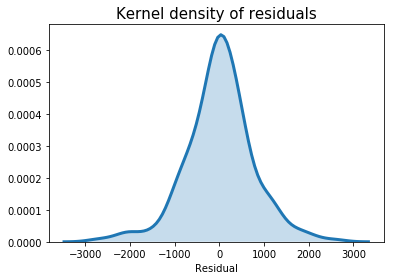

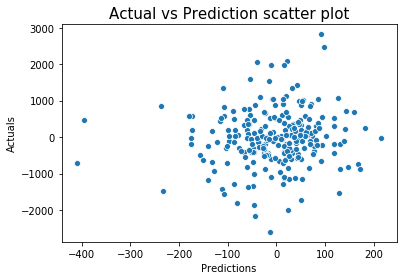

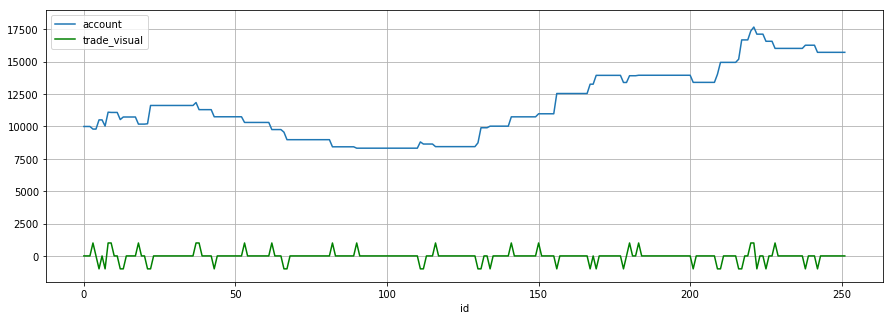

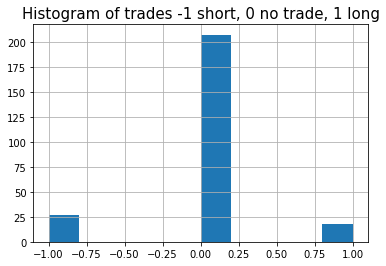

In [74]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=100)

In [75]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 175904
[2]	valid_0's l2: 175905
[3]	valid_0's l2: 175907
[4]	valid_0's l2: 175908
[5]	valid_0's l2: 175900
[6]	valid_0's l2: 175902
[7]	valid_0's l2: 175894
[8]	valid_0's l2: 175893
[9]	valid_0's l2: 175895
[10]	valid_0's l2: 175887
[11]	valid_0's l2: 175889
[12]	valid_0's l2: 175888
[13]	valid_0's l2: 175881
[14]	valid_0's l2: 175883
[15]	valid_0's l2: 175876
[16]	valid_0's l2: 175877
[17]	valid_0's l2: 175870
[18]	valid_0's l2: 175872
[19]	valid_0's l2: 175866
[20]	valid_0's l2: 175869
[21]	valid_0's l2: 175867
[22]	valid_0's l2: 175860
[23]	valid_0's l2: 175863
[24]	valid_0's l2: 175856
[25]	valid_0's l2: 175859
[26]	valid_0's l2: 175853
[27]	valid_0's l2: 175855
[28]	valid_0's l2: 175855
[29]	valid_0's l2: 175850
[30]	valid_0's l2: 175852
[31]	valid_0's l2: 175852
[32]	valid_0's l2: 175847
[33]	valid_0's l2: 175849
[34]	valid_0's l2: 175849
[35]	valid_0's l2: 175850
[36]	valid_0's l2: 175850
[37]	valid_0's l2: 175852
[38]	valid_0's l2: 175849
[39]	valid_0's l2: 17

[348]	valid_0's l2: 175843
[349]	valid_0's l2: 175841
[350]	valid_0's l2: 175840
[351]	valid_0's l2: 175838
[352]	valid_0's l2: 175832
[353]	valid_0's l2: 175834
[354]	valid_0's l2: 175834
[355]	valid_0's l2: 175834
[356]	valid_0's l2: 175831
[357]	valid_0's l2: 175831
[358]	valid_0's l2: 175828
[359]	valid_0's l2: 175827
[360]	valid_0's l2: 175829
[361]	valid_0's l2: 175829
[362]	valid_0's l2: 175826
[363]	valid_0's l2: 175826
[364]	valid_0's l2: 175825
[365]	valid_0's l2: 175819
[366]	valid_0's l2: 175819
[367]	valid_0's l2: 175819
[368]	valid_0's l2: 175822
[369]	valid_0's l2: 175822
[370]	valid_0's l2: 175828
[371]	valid_0's l2: 175828
[372]	valid_0's l2: 175825
[373]	valid_0's l2: 175826
[374]	valid_0's l2: 175822
[375]	valid_0's l2: 175822
[376]	valid_0's l2: 175821
[377]	valid_0's l2: 175819
[378]	valid_0's l2: 175819
[379]	valid_0's l2: 175818
[380]	valid_0's l2: 175829
[381]	valid_0's l2: 175828
[382]	valid_0's l2: 175828
[383]	valid_0's l2: 175830
[384]	valid_0's l2: 175830
[

[668]	valid_0's l2: 175897
[669]	valid_0's l2: 175900
[670]	valid_0's l2: 175904
[671]	valid_0's l2: 175903
[672]	valid_0's l2: 175907
[673]	valid_0's l2: 175906
[674]	valid_0's l2: 175907
[675]	valid_0's l2: 175911
[676]	valid_0's l2: 175916
[677]	valid_0's l2: 175919
[678]	valid_0's l2: 175918
[679]	valid_0's l2: 175923
[680]	valid_0's l2: 175926
[681]	valid_0's l2: 175925
[682]	valid_0's l2: 175924
[683]	valid_0's l2: 175929
[684]	valid_0's l2: 175928
[685]	valid_0's l2: 175927
[686]	valid_0's l2: 175915
[687]	valid_0's l2: 175914
[688]	valid_0's l2: 175913
[689]	valid_0's l2: 175916
[690]	valid_0's l2: 175913
[691]	valid_0's l2: 175912
[692]	valid_0's l2: 175912
[693]	valid_0's l2: 175909
[694]	valid_0's l2: 175912
[695]	valid_0's l2: 175911
[696]	valid_0's l2: 175898
[697]	valid_0's l2: 175903
[698]	valid_0's l2: 175910
[699]	valid_0's l2: 175909
[700]	valid_0's l2: 175906
[701]	valid_0's l2: 175895
[702]	valid_0's l2: 175895
[703]	valid_0's l2: 175894
[704]	valid_0's l2: 175894
[

[988]	valid_0's l2: 175861
[989]	valid_0's l2: 175860
[990]	valid_0's l2: 175859
[991]	valid_0's l2: 175867
[992]	valid_0's l2: 175869
[993]	valid_0's l2: 175868
[994]	valid_0's l2: 175878
[995]	valid_0's l2: 175877
[996]	valid_0's l2: 175885
[997]	valid_0's l2: 175889
[998]	valid_0's l2: 175888
[999]	valid_0's l2: 175879
[1000]	valid_0's l2: 175878


Predictions/Actual volatility correlation:  0.030004906267008552
Returns  2.48 %
Number of trades:  36
Number of short trades:  14
Number of long trades:  22
Earnings per trade:  6.89
Earnings per short trade:  43.29
Earnings per long trade:  -16.28


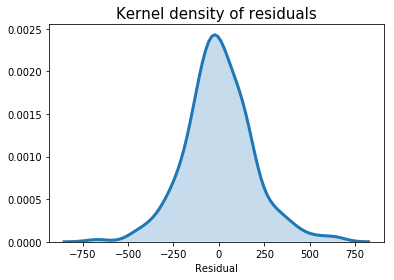

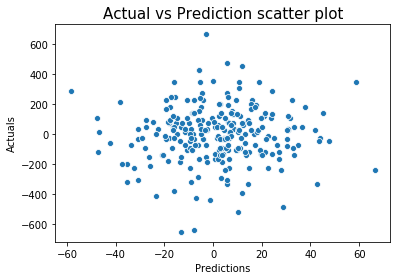

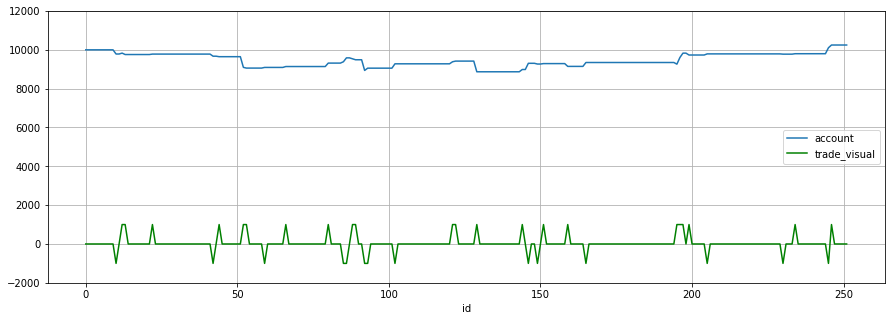

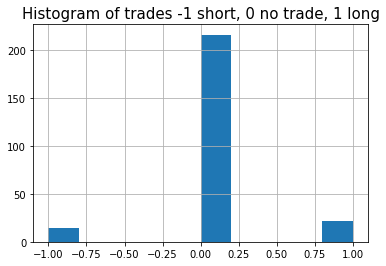

In [144]:
corn_account_lgb = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=30)

In [77]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test)

coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 161691
[2]	valid_0's l2: 161691
[3]	valid_0's l2: 161691
[4]	valid_0's l2: 161692
[5]	valid_0's l2: 161693
[6]	valid_0's l2: 161693
[7]	valid_0's l2: 161695
[8]	valid_0's l2: 161695
[9]	valid_0's l2: 161695
[10]	valid_0's l2: 161697
[11]	valid_0's l2: 161701
[12]	valid_0's l2: 161700
[13]	valid_0's l2: 161701
[14]	valid_0's l2: 161704
[15]	valid_0's l2: 161706
[16]	valid_0's l2: 161709
[17]	valid_0's l2: 161700
[18]	valid_0's l2: 161704
[19]	valid_0's l2: 161695
[20]	valid_0's l2: 161699
[21]	valid_0's l2: 161698
[22]	valid_0's l2: 161690
[23]	valid_0's l2: 161694
[24]	valid_0's l2: 161685
[25]	valid_0's l2: 161690
[26]	valid_0's l2: 161692
[27]	valid_0's l2: 161686
[28]	valid_0's l2: 161684
[29]	valid_0's l2: 161685
[30]	valid_0's l2: 161679
[31]	valid_0's l2: 161679
[32]	valid_0's l2: 161685
[33]	valid_0's l2: 161683
[34]	valid_0's l2: 161683
[35]	valid_0's l2: 161683
[36]	valid_0's l2: 161684
[37]	valid_0's l2: 161690
[38]	valid_0's l2: 161688
[39]	valid_0's l2: 16

[323]	valid_0's l2: 161413
[324]	valid_0's l2: 161414
[325]	valid_0's l2: 161416
[326]	valid_0's l2: 161417
[327]	valid_0's l2: 161421
[328]	valid_0's l2: 161423
[329]	valid_0's l2: 161415
[330]	valid_0's l2: 161417
[331]	valid_0's l2: 161419
[332]	valid_0's l2: 161420
[333]	valid_0's l2: 161421
[334]	valid_0's l2: 161423
[335]	valid_0's l2: 161427
[336]	valid_0's l2: 161428
[337]	valid_0's l2: 161425
[338]	valid_0's l2: 161429
[339]	valid_0's l2: 161429
[340]	valid_0's l2: 161430
[341]	valid_0's l2: 161437
[342]	valid_0's l2: 161428
[343]	valid_0's l2: 161432
[344]	valid_0's l2: 161433
[345]	valid_0's l2: 161425
[346]	valid_0's l2: 161423
[347]	valid_0's l2: 161424
[348]	valid_0's l2: 161430
[349]	valid_0's l2: 161421
[350]	valid_0's l2: 161422
[351]	valid_0's l2: 161421
[352]	valid_0's l2: 161426
[353]	valid_0's l2: 161418
[354]	valid_0's l2: 161419
[355]	valid_0's l2: 161420
[356]	valid_0's l2: 161416
[357]	valid_0's l2: 161417
[358]	valid_0's l2: 161421
[359]	valid_0's l2: 161421
[

[640]	valid_0's l2: 161733
[641]	valid_0's l2: 161732
[642]	valid_0's l2: 161732
[643]	valid_0's l2: 161739
[644]	valid_0's l2: 161738
[645]	valid_0's l2: 161747
[646]	valid_0's l2: 161747
[647]	valid_0's l2: 161757
[648]	valid_0's l2: 161754
[649]	valid_0's l2: 161753
[650]	valid_0's l2: 161753
[651]	valid_0's l2: 161760
[652]	valid_0's l2: 161760
[653]	valid_0's l2: 161759
[654]	valid_0's l2: 161759
[655]	valid_0's l2: 161770
[656]	valid_0's l2: 161769
[657]	valid_0's l2: 161769
[658]	valid_0's l2: 161765
[659]	valid_0's l2: 161764
[660]	valid_0's l2: 161775
[661]	valid_0's l2: 161774
[662]	valid_0's l2: 161780
[663]	valid_0's l2: 161780
[664]	valid_0's l2: 161779
[665]	valid_0's l2: 161779
[666]	valid_0's l2: 161778
[667]	valid_0's l2: 161778
[668]	valid_0's l2: 161777
[669]	valid_0's l2: 161770
[670]	valid_0's l2: 161776
[671]	valid_0's l2: 161775
[672]	valid_0's l2: 161773
[673]	valid_0's l2: 161773
[674]	valid_0's l2: 161782
[675]	valid_0's l2: 161788
[676]	valid_0's l2: 161799
[

[976]	valid_0's l2: 162181
[977]	valid_0's l2: 162180
[978]	valid_0's l2: 162191
[979]	valid_0's l2: 162190
[980]	valid_0's l2: 162198
[981]	valid_0's l2: 162197
[982]	valid_0's l2: 162195
[983]	valid_0's l2: 162191
[984]	valid_0's l2: 162189
[985]	valid_0's l2: 162188
[986]	valid_0's l2: 162188
[987]	valid_0's l2: 162186
[988]	valid_0's l2: 162196
[989]	valid_0's l2: 162195
[990]	valid_0's l2: 162195
[991]	valid_0's l2: 162192
[992]	valid_0's l2: 162200
[993]	valid_0's l2: 162199
[994]	valid_0's l2: 162210
[995]	valid_0's l2: 162209
[996]	valid_0's l2: 162211
[997]	valid_0's l2: 162211
[998]	valid_0's l2: 162210
[999]	valid_0's l2: 162212
[1000]	valid_0's l2: 162212


Predictions/Actual volatility correlation:  -0.03164539084652848
Returns  34.10 %
Number of trades:  45
Number of short trades:  30
Number of long trades:  15
Earnings per trade:  75.78
Earnings per short trade:  158.71
Earnings per long trade:  -90.07


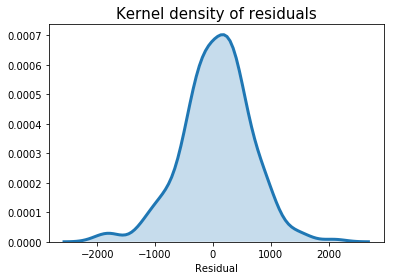

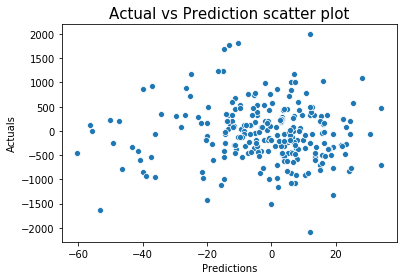

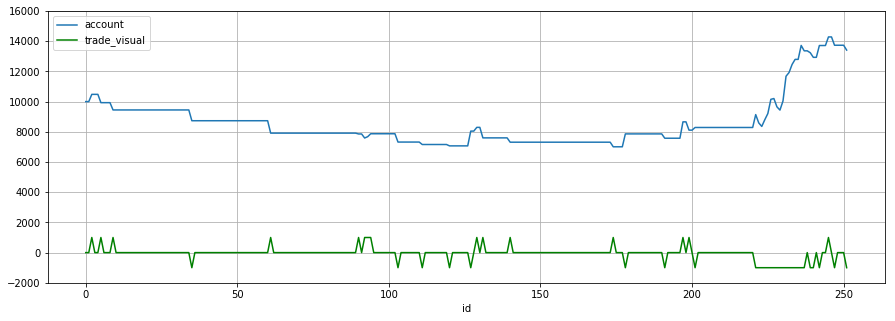

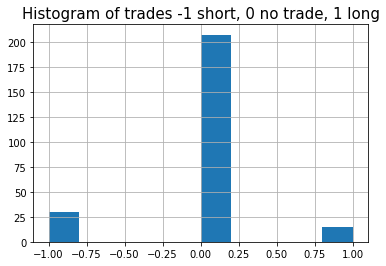

In [145]:
coffee_account_lgb = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=20)

# Neural Networks classifier
---


| commodity | gains % | earnings per trade | number of trades |
|-----------|---------|--------------------|------------------|
| gold      | 125     | 73.17              | 172              |
| corn      | 7       | 5.2                | 141              |
| coffee   | -100    | -90.6              | 111              |

In [79]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [80]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [81]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    opt = RMSprop(lr=0.0001)
    
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
batch_size = 20
epochs = 200
model = define_model(input_shape, num_classes)

Using TensorFlow backend.


In [82]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [83]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()

Train on 1931 samples, validate on 484 samples
Epoch 1/200
1931/1931 [==============================] - 1s 584us/step - loss: 74620057768.6339 - acc: 0.3304 - val_loss: 71165075413.6859 - val_acc: 0.3202

Epoch 00001: val_loss improved from inf to 71165075413.68594, saving model to saved_models/weights.gold.hdf5
Epoch 2/200
1931/1931 [==============================] - 0s 105us/step - loss: 68404211446.8524 - acc: 0.3190 - val_loss: 65184535662.0165 - val_acc: 0.3120

Epoch 00002: val_loss improved from 71165075413.68594 to 65184535662.01653, saving model to saved_models/weights.gold.hdf5
Epoch 3/200
1931/1931 [==============================] - 0s 102us/step - loss: 62591839305.7110 - acc: 0.3330 - val_loss: 59571930712.8595 - val_acc: 0.3347

Epoch 00003: val_loss improved from 65184535662.01653 to 59571930712.85950, saving model to saved_models/weights.gold.hdf5
Epoch 4/200
1931/1931 [==============================] - 0s 98us/step - loss: 57195974675.0906 - acc: 0.3553 - val_loss: 543

1931/1931 [==============================] - 0s 99us/step - loss: 184199.3638 - acc: 0.3521 - val_loss: 174378.6090 - val_acc: 0.2955

Epoch 00064: val_loss did not improve from 159266.02964
Epoch 65/200
1931/1931 [==============================] - 0s 121us/step - loss: 182765.4701 - acc: 0.3361 - val_loss: 199361.9918 - val_acc: 0.2996

Epoch 00065: val_loss did not improve from 159266.02964
Epoch 66/200
1931/1931 [==============================] - 0s 97us/step - loss: 181716.4688 - acc: 0.3413 - val_loss: 191273.9390 - val_acc: 0.2851

Epoch 00066: val_loss did not improve from 159266.02964
Epoch 67/200
1931/1931 [==============================] - 0s 96us/step - loss: 185874.9413 - acc: 0.3143 - val_loss: 189894.1287 - val_acc: 0.2996

Epoch 00067: val_loss did not improve from 159266.02964
Epoch 68/200
1931/1931 [==============================] - 0s 99us/step - loss: 182728.1201 - acc: 0.3123 - val_loss: 174698.9873 - val_acc: 0.3182

Epoch 00068: val_loss did not improve from 15926

1931/1931 [==============================] - 0s 115us/step - loss: 183623.2082 - acc: 0.3149 - val_loss: 168161.5876 - val_acc: 0.3182

Epoch 00104: val_loss did not improve from 159266.02964
Epoch 105/200
1931/1931 [==============================] - 0s 110us/step - loss: 179532.7025 - acc: 0.3066 - val_loss: 171426.8135 - val_acc: 0.3223

Epoch 00105: val_loss did not improve from 159266.02964
Epoch 106/200
1931/1931 [==============================] - 0s 118us/step - loss: 182896.2781 - acc: 0.3180 - val_loss: 179772.8648 - val_acc: 0.3017

Epoch 00106: val_loss did not improve from 159266.02964
Epoch 107/200
1931/1931 [==============================] - 0s 117us/step - loss: 181763.5516 - acc: 0.3252 - val_loss: 189044.9166 - val_acc: 0.2913

Epoch 00107: val_loss did not improve from 159266.02964
Epoch 108/200
1931/1931 [==============================] - 0s 108us/step - loss: 182515.4754 - acc: 0.3299 - val_loss: 165862.6017 - val_acc: 0.3161

Epoch 00108: val_loss did not improve fr


Epoch 00143: val_loss did not improve from 153106.75294
Epoch 144/200
1931/1931 [==============================] - 0s 120us/step - loss: 184532.9247 - acc: 0.3216 - val_loss: 179468.8196 - val_acc: 0.3264

Epoch 00144: val_loss did not improve from 153106.75294
Epoch 145/200
1931/1931 [==============================] - 0s 114us/step - loss: 183244.6033 - acc: 0.3180 - val_loss: 170079.0876 - val_acc: 0.3223

Epoch 00145: val_loss did not improve from 153106.75294
Epoch 146/200
1931/1931 [==============================] - 0s 124us/step - loss: 182915.6897 - acc: 0.3325 - val_loss: 180147.8792 - val_acc: 0.3161

Epoch 00146: val_loss did not improve from 153106.75294
Epoch 147/200
1931/1931 [==============================] - 0s 106us/step - loss: 184611.9112 - acc: 0.3247 - val_loss: 188035.8601 - val_acc: 0.2769

Epoch 00147: val_loss did not improve from 153106.75294
Epoch 148/200
1931/1931 [==============================] - 0s 95us/step - loss: 181816.3931 - acc: 0.3175 - val_loss: 1


Epoch 00183: val_loss did not improve from 153106.75294
Epoch 184/200
1931/1931 [==============================] - 0s 102us/step - loss: 183951.8963 - acc: 0.3314 - val_loss: 194470.5647 - val_acc: 0.3182

Epoch 00184: val_loss did not improve from 153106.75294
Epoch 185/200
1931/1931 [==============================] - 0s 101us/step - loss: 181089.3845 - acc: 0.3314 - val_loss: 194408.3969 - val_acc: 0.3326

Epoch 00185: val_loss did not improve from 153106.75294
Epoch 186/200
1931/1931 [==============================] - 0s 104us/step - loss: 181810.3534 - acc: 0.3278 - val_loss: 207499.1855 - val_acc: 0.3347

Epoch 00186: val_loss did not improve from 153106.75294
Epoch 187/200
1931/1931 [==============================] - 0s 100us/step - loss: 183169.5757 - acc: 0.3345 - val_loss: 183909.3257 - val_acc: 0.3037

Epoch 00187: val_loss did not improve from 153106.75294
Epoch 188/200
1931/1931 [==============================] - 0s 92us/step - loss: 185801.3639 - acc: 0.3118 - val_loss: 1

In [84]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

Returns  125.86 %
Number of trades:  172
Number of short trades:  22
Number of long trades:  150
Earnings per trade:  73.17
Earnings per short trade:  147.93
Earnings per long trade:  62.21


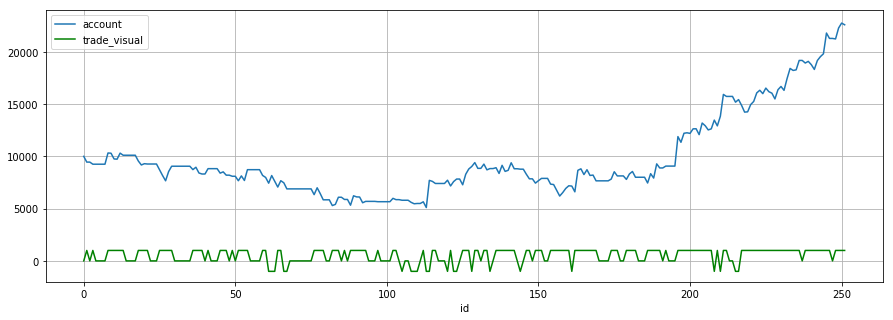

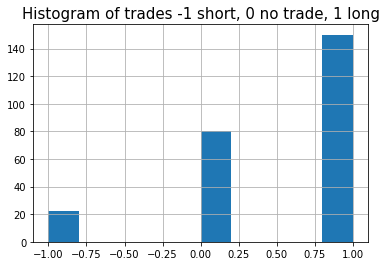

In [85]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [86]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1930 samples, validate on 483 samples
Epoch 1/200
1930/1930 [==============================] - 1s 546us/step - loss: 72755595041.1606 - acc: 0.3389 - val_loss: 68095127179.9255 - val_acc: 0.3727

Epoch 00001: val_loss improved from inf to 68095127179.92547, saving model to saved_models/weights.corn.hdf5
Epoch 2/200
1930/1930 [==============================] - 0s 121us/step - loss: 65932506043.0259 - acc: 0.3275 - val_loss: 61669199382.2609 - val_acc: 0.3727

Epoch 00002: val_loss improved from 68095127179.92547 to 61669199382.26087, saving model to saved_models/weights.corn.hdf5
Epoch 3/200
1930/1930 [==============================] - 0s 135us/step - loss: 59673001018.3627 - acc: 0.3389 - val_loss: 55781060729.9048 - val_acc: 0.3768

Epoch 00003: val_loss improved from 61669199382.26087 to 55781060729.90476, saving model to saved_models/weights.corn.hdf5
Epoch 4/200
1930/1930 [==============================] - 0s 123us/step - loss: 53917149852.5181 - acc: 0.3477 - val_loss: 50

1930/1930 [==============================] - 0s 109us/step - loss: 155139.8725 - acc: 0.3311 - val_loss: 160959.7911 - val_acc: 0.3168

Epoch 00064: val_loss did not improve from 122159.13582
Epoch 65/200
1930/1930 [==============================] - 0s 105us/step - loss: 155263.0209 - acc: 0.3487 - val_loss: 169765.1936 - val_acc: 0.3561

Epoch 00065: val_loss did not improve from 122159.13582
Epoch 66/200
1930/1930 [==============================] - 0s 105us/step - loss: 156311.2245 - acc: 0.3456 - val_loss: 177334.7072 - val_acc: 0.3561

Epoch 00066: val_loss did not improve from 122159.13582
Epoch 67/200
1930/1930 [==============================] - 0s 102us/step - loss: 156531.9936 - acc: 0.3663 - val_loss: 151562.2803 - val_acc: 0.3416

Epoch 00067: val_loss did not improve from 122159.13582
Epoch 68/200
1930/1930 [==============================] - 0s 235us/step - loss: 158342.4715 - acc: 0.3601 - val_loss: 148212.3367 - val_acc: 0.3540

Epoch 00068: val_loss did not improve from 1

1930/1930 [==============================] - 0s 108us/step - loss: 156821.1493 - acc: 0.3591 - val_loss: 161035.8866 - val_acc: 0.3106

Epoch 00104: val_loss did not improve from 122159.13582
Epoch 105/200
1930/1930 [==============================] - 0s 138us/step - loss: 156383.1644 - acc: 0.3539 - val_loss: 151371.6675 - val_acc: 0.3520

Epoch 00105: val_loss did not improve from 122159.13582
Epoch 106/200
1930/1930 [==============================] - 0s 99us/step - loss: 157885.2963 - acc: 0.3295 - val_loss: 132053.2423 - val_acc: 0.3147

Epoch 00106: val_loss did not improve from 122159.13582
Epoch 107/200
1930/1930 [==============================] - 0s 111us/step - loss: 156535.1397 - acc: 0.3383 - val_loss: 150307.2364 - val_acc: 0.3582

Epoch 00107: val_loss did not improve from 122159.13582
Epoch 108/200
1930/1930 [==============================] - 0s 99us/step - loss: 156756.3856 - acc: 0.3591 - val_loss: 174603.5524 - val_acc: 0.3582

Epoch 00108: val_loss did not improve from

1930/1930 [==============================] - 0s 149us/step - loss: 160010.7860 - acc: 0.3430 - val_loss: 147340.8434 - val_acc: 0.3665

Epoch 00144: val_loss did not improve from 122159.13582
Epoch 145/200
1930/1930 [==============================] - 0s 125us/step - loss: 155715.9610 - acc: 0.3326 - val_loss: 186186.9145 - val_acc: 0.3333

Epoch 00145: val_loss did not improve from 122159.13582
Epoch 146/200
1930/1930 [==============================] - 0s 121us/step - loss: 155552.3932 - acc: 0.3446 - val_loss: 150301.5956 - val_acc: 0.3106

Epoch 00146: val_loss did not improve from 122159.13582
Epoch 147/200
1930/1930 [==============================] - 0s 100us/step - loss: 155274.3264 - acc: 0.3425 - val_loss: 188783.2136 - val_acc: 0.3395

Epoch 00147: val_loss did not improve from 122159.13582
Epoch 148/200
1930/1930 [==============================] - 0s 101us/step - loss: 157269.5054 - acc: 0.3617 - val_loss: 163264.7931 - val_acc: 0.3520

Epoch 00148: val_loss did not improve fr

1930/1930 [==============================] - 0s 168us/step - loss: 155226.3960 - acc: 0.3301 - val_loss: 154133.6398 - val_acc: 0.3292

Epoch 00184: val_loss did not improve from 122159.13582
Epoch 185/200
1930/1930 [==============================] - 0s 144us/step - loss: 158271.7905 - acc: 0.3544 - val_loss: 153926.7727 - val_acc: 0.3188

Epoch 00185: val_loss did not improve from 122159.13582
Epoch 186/200
1930/1930 [==============================] - 0s 210us/step - loss: 155469.3415 - acc: 0.3311 - val_loss: 150047.2678 - val_acc: 0.3375

Epoch 00186: val_loss did not improve from 122159.13582
Epoch 187/200
1930/1930 [==============================] - 0s 158us/step - loss: 157274.3720 - acc: 0.3358 - val_loss: 160678.2375 - val_acc: 0.3333

Epoch 00187: val_loss did not improve from 122159.13582
Epoch 188/200
1930/1930 [==============================] - 0s 142us/step - loss: 156289.2314 - acc: 0.3430 - val_loss: 175736.3947 - val_acc: 0.3375

Epoch 00188: val_loss did not improve fr

Returns  7.33 %
Number of trades:  141
Number of short trades:  85
Number of long trades:  56
Earnings per trade:  5.20
Earnings per short trade:  -14.76
Earnings per long trade:  35.49


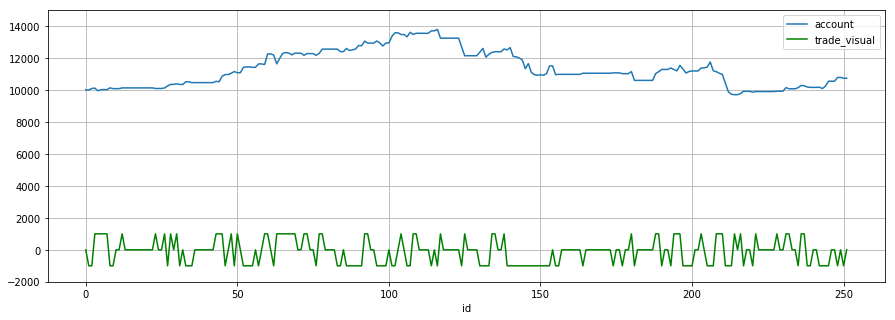

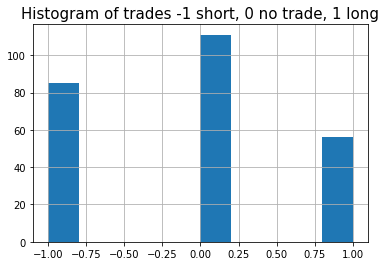

In [87]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [88]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_coffee)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/200
1923/1923 [==============================] - 1s 633us/step - loss: 4493543648.5741 - acc: 0.2985 - val_loss: 4459361713.7630 - val_acc: 0.3181

Epoch 00001: val_loss improved from inf to 4459361713.76299, saving model to saved_models/weights.coffee.hdf5
Epoch 2/200
1923/1923 [==============================] - 0s 123us/step - loss: 4321701877.6162 - acc: 0.3063 - val_loss: 4306511720.8482 - val_acc: 0.3035

Epoch 00002: val_loss improved from 4459361713.76299 to 4306511720.84823, saving model to saved_models/weights.coffee.hdf5
Epoch 3/200
1923/1923 [==============================] - 0s 124us/step - loss: 4184369565.4124 - acc: 0.2980 - val_loss: 4156741989.1227 - val_acc: 0.3035

Epoch 00003: val_loss improved from 4306511720.84823 to 4156741989.12266, saving model to saved_models/weights.coffee.hdf5
Epoch 4/200
1923/1923 [==============================] - 0s 143us/step - loss: 4034359366.5897 - acc: 0.3094 - val_loss: 40130066

Epoch 60/200
1923/1923 [==============================] - 0s 110us/step - loss: 131044691.4363 - acc: 0.3068 - val_loss: 117979969.6923 - val_acc: 0.3222

Epoch 00060: val_loss improved from 137003674.09563 to 117979969.69231, saving model to saved_models/weights.coffee.hdf5
Epoch 61/200
1923/1923 [==============================] - 0s 129us/step - loss: 112924122.2050 - acc: 0.3271 - val_loss: 100390678.2453 - val_acc: 0.3306

Epoch 00061: val_loss improved from 117979969.69231 to 100390678.24532, saving model to saved_models/weights.coffee.hdf5
Epoch 62/200
1923/1923 [==============================] - 0s 118us/step - loss: 95972220.3390 - acc: 0.3162 - val_loss: 84547516.9667 - val_acc: 0.3222

Epoch 00062: val_loss improved from 100390678.24532 to 84547516.96674, saving model to saved_models/weights.coffee.hdf5
Epoch 63/200
1923/1923 [==============================] - 0s 109us/step - loss: 80493789.6048 - acc: 0.3172 - val_loss: 69972678.4387 - val_acc: 0.3202

Epoch 00063: val_loss 

1923/1923 [==============================] - 0s 104us/step - loss: 51796.6343 - acc: 0.3224 - val_loss: 52353.5678 - val_acc: 0.3326

Epoch 00134: val_loss did not improve from 45092.91183
Epoch 135/200
1923/1923 [==============================] - 0s 108us/step - loss: 51047.2276 - acc: 0.3188 - val_loss: 54354.2569 - val_acc: 0.3243

Epoch 00135: val_loss did not improve from 45092.91183
Epoch 136/200
1923/1923 [==============================] - 0s 132us/step - loss: 52435.8552 - acc: 0.3177 - val_loss: 53798.8026 - val_acc: 0.3784

Epoch 00136: val_loss did not improve from 45092.91183
Epoch 137/200
1923/1923 [==============================] - 0s 113us/step - loss: 51514.2621 - acc: 0.3224 - val_loss: 50826.7877 - val_acc: 0.3659

Epoch 00137: val_loss did not improve from 45092.91183
Epoch 138/200
1923/1923 [==============================] - 0s 130us/step - loss: 52000.7786 - acc: 0.3214 - val_loss: 51354.8460 - val_acc: 0.3410

Epoch 00138: val_loss did not improve from 45092.91183

Returns  -100.60 %
Number of trades:  111
Number of short trades:  46
Number of long trades:  65
Earnings per trade:  -90.63
Earnings per short trade:  0.88
Earnings per long trade:  -155.39


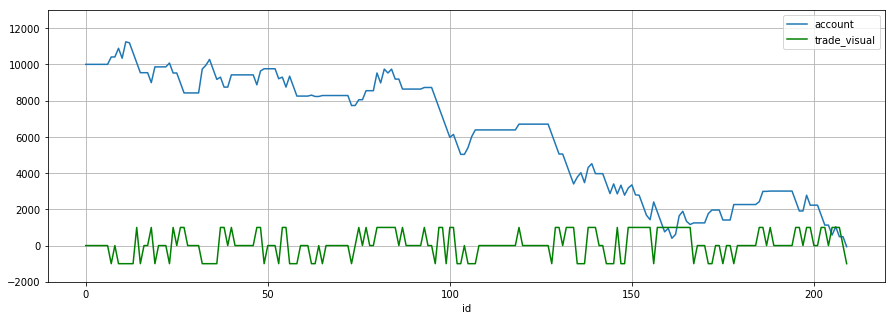

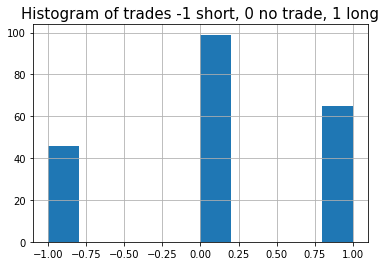

In [89]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=300, stop_loss_short=300)

# Neural network regressor

I have decided to use weighted in loss function with weight $0.75$. This is because errors around $0$ does not matter because I want to trigger trades when volatility reaches threshold.

Model performance
---


| commodity | gains % | earnings per trade | number of trades | test/real correlation |
|-----------|---------|--------------------|------------------|-----------------------|
| gold      | 232     | 180                | 129              | 0.14                  |
| corn      | -74     | -65                | 113              | -0.025                |
| coffee   | -12.92  | -56                | 23               | -0.020                |

In [90]:
import keras
import tensorflow as tf
from tensorflow.losses import mean_squared_error
from keras.optimizers import Nadam


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
# optimizer = 'Adam'
optimizer = Nadam(lr=0.0001)

def regressor_model():
    global input_shape
    global loss
    global optimizer
    # Define a model
    #     model = Sequential()  
    #     model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.4))
    #     model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.3))
    #     model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.2))
    #     # model.add(Dense(1))
    #     # model.add(Activation('tanh'))
    #     model.add(Dense(1, kernel_initializer='normal'))
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [91]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 1000
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [92]:
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1931 samples, validate on 484 samples
Epoch 1/1000
1931/1931 [==============================] - 2s 956us/step - loss: 1277692.7881 - val_loss: 1215194.6413

Epoch 00001: val_loss improved from inf to 1215194.64127, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/1000
1931/1931 [==============================] - 0s 151us/step - loss: 1277726.8075 - val_loss: 1215194.4651

Epoch 00002: val_loss improved from 1215194.64127 to 1215194.46513, saving model to saved_models/weights.gold_reg.hdf5
Epoch 3/1000
1931/1931 [==============================] - 0s 147us/step - loss: 1277731.5354 - val_loss: 1215194.5979

Epoch 00003: val_loss did not improve from 1215194.46513
Epoch 4/1000
1931/1931 [==============================] - 0s 151us/step - loss: 1277716.0748 - val_loss: 1215194.9533

Epoch 00004: val_loss did not improve from 1215194.46513
Epoch 5/1000
1931/1931 [==============================] - 0s 153us/step - loss: 1277715.4905 - val_loss: 1215194.6885

Epoch 00005: val

1931/1931 [==============================] - 0s 143us/step - loss: 1277316.4235 - val_loss: 1215149.5121

Epoch 00039: val_loss improved from 1215153.62087 to 1215149.51214, saving model to saved_models/weights.gold_reg.hdf5
Epoch 40/1000
1931/1931 [==============================] - 0s 148us/step - loss: 1277199.9608 - val_loss: 1215144.9837

Epoch 00040: val_loss improved from 1215149.51214 to 1215144.98373, saving model to saved_models/weights.gold_reg.hdf5
Epoch 41/1000
1931/1931 [==============================] - 0s 148us/step - loss: 1277188.4499 - val_loss: 1215135.6240

Epoch 00041: val_loss improved from 1215144.98373 to 1215135.62397, saving model to saved_models/weights.gold_reg.hdf5
Epoch 42/1000
1931/1931 [==============================] - 0s 142us/step - loss: 1277221.1595 - val_loss: 1215124.6746

Epoch 00042: val_loss improved from 1215135.62397 to 1215124.67459, saving model to saved_models/weights.gold_reg.hdf5
Epoch 43/1000
1931/1931 [==============================] -

1931/1931 [==============================] - 0s 145us/step - loss: 1272102.1882 - val_loss: 1214707.2887

Epoch 00075: val_loss improved from 1214721.57696 to 1214707.28874, saving model to saved_models/weights.gold_reg.hdf5
Epoch 76/1000
1931/1931 [==============================] - 0s 146us/step - loss: 1271828.4663 - val_loss: 1214712.6330

Epoch 00076: val_loss did not improve from 1214707.28874
Epoch 77/1000
1931/1931 [==============================] - 0s 147us/step - loss: 1271567.9195 - val_loss: 1214716.8512

Epoch 00077: val_loss did not improve from 1214707.28874
Epoch 78/1000
1931/1931 [==============================] - 0s 140us/step - loss: 1271708.0051 - val_loss: 1214703.0832

Epoch 00078: val_loss improved from 1214707.28874 to 1214703.08316, saving model to saved_models/weights.gold_reg.hdf5
Epoch 79/1000
1931/1931 [==============================] - 0s 141us/step - loss: 1271423.9884 - val_loss: 1214655.5788

Epoch 00079: val_loss improved from 1214703.08316 to 1214655.5


Epoch 00155: val_loss did not improve from 1213972.98760
Epoch 156/1000
1931/1931 [==============================] - 0s 131us/step - loss: 1249812.5975 - val_loss: 1214109.8140

Epoch 00156: val_loss did not improve from 1213972.98760
Epoch 157/1000
1931/1931 [==============================] - 0s 139us/step - loss: 1249925.8213 - val_loss: 1214153.8667

Epoch 00157: val_loss did not improve from 1213972.98760
Epoch 158/1000
1931/1931 [==============================] - 0s 134us/step - loss: 1248264.4320 - val_loss: 1214195.0966

Epoch 00158: val_loss did not improve from 1213972.98760
Epoch 159/1000
1931/1931 [==============================] - 0s 134us/step - loss: 1250167.4307 - val_loss: 1214241.2975

Epoch 00159: val_loss did not improve from 1213972.98760
Epoch 160/1000
1931/1931 [==============================] - 0s 151us/step - loss: 1249272.1554 - val_loss: 1214209.7342

Epoch 00160: val_loss did not improve from 1213972.98760
Epoch 161/1000
1931/1931 [==========================


Epoch 00197: val_loss did not improve from 1213414.90341
Epoch 198/1000
1931/1931 [==============================] - 0s 142us/step - loss: 1234904.8996 - val_loss: 1213531.3270

Epoch 00198: val_loss did not improve from 1213414.90341
Epoch 199/1000
1931/1931 [==============================] - 0s 141us/step - loss: 1233181.0943 - val_loss: 1213556.2616

Epoch 00199: val_loss did not improve from 1213414.90341
Epoch 200/1000
1931/1931 [==============================] - 0s 137us/step - loss: 1233686.8000 - val_loss: 1213640.2017

Epoch 00200: val_loss did not improve from 1213414.90341
Epoch 201/1000
1931/1931 [==============================] - 0s 140us/step - loss: 1233806.3856 - val_loss: 1213620.2745

Epoch 00201: val_loss did not improve from 1213414.90341
Epoch 202/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1232135.5747 - val_loss: 1213526.4370

Epoch 00202: val_loss did not improve from 1213414.90341
Epoch 203/1000
1931/1931 [==========================


Epoch 00282: val_loss did not improve from 1212125.88430
Epoch 283/1000
1931/1931 [==============================] - 0s 137us/step - loss: 1192795.1425 - val_loss: 1212061.2355

Epoch 00283: val_loss improved from 1212125.88430 to 1212061.23554, saving model to saved_models/weights.gold_reg.hdf5
Epoch 284/1000
1931/1931 [==============================] - 0s 139us/step - loss: 1192517.8544 - val_loss: 1212122.6387

Epoch 00284: val_loss did not improve from 1212061.23554
Epoch 285/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1194145.5575 - val_loss: 1212209.1772

Epoch 00285: val_loss did not improve from 1212061.23554
Epoch 286/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1192908.8770 - val_loss: 1212279.9574

Epoch 00286: val_loss did not improve from 1212061.23554
Epoch 287/1000
1931/1931 [==============================] - 0s 144us/step - loss: 1193717.4132 - val_loss: 1212244.3461

Epoch 00287: val_loss did not improve from 1212

1931/1931 [==============================] - 0s 141us/step - loss: 1145179.7556 - val_loss: 1211004.9246

Epoch 00368: val_loss did not improve from 1210378.53435
Epoch 369/1000
1931/1931 [==============================] - 0s 144us/step - loss: 1149475.9995 - val_loss: 1210807.9024

Epoch 00369: val_loss did not improve from 1210378.53435
Epoch 370/1000
1931/1931 [==============================] - 0s 136us/step - loss: 1146239.2001 - val_loss: 1210801.1118

Epoch 00370: val_loss did not improve from 1210378.53435
Epoch 371/1000
1931/1931 [==============================] - 0s 150us/step - loss: 1143512.5277 - val_loss: 1210930.7477

Epoch 00371: val_loss did not improve from 1210378.53435
Epoch 372/1000
1931/1931 [==============================] - 0s 146us/step - loss: 1143334.3732 - val_loss: 1210761.3856

Epoch 00372: val_loss did not improve from 1210378.53435
Epoch 373/1000
1931/1931 [==============================] - 0s 148us/step - loss: 1141022.6718 - val_loss: 1210824.2926

Epoc


Epoch 00411: val_loss improved from 1209789.61415 to 1209779.90548, saving model to saved_models/weights.gold_reg.hdf5
Epoch 412/1000
1931/1931 [==============================] - 0s 142us/step - loss: 1122466.8256 - val_loss: 1209643.8308

Epoch 00412: val_loss improved from 1209779.90548 to 1209643.83084, saving model to saved_models/weights.gold_reg.hdf5
Epoch 413/1000
1931/1931 [==============================] - 0s 144us/step - loss: 1119482.8602 - val_loss: 1209667.5201

Epoch 00413: val_loss did not improve from 1209643.83084
Epoch 414/1000
1931/1931 [==============================] - 0s 139us/step - loss: 1119305.4404 - val_loss: 1209770.9277

Epoch 00414: val_loss did not improve from 1209643.83084
Epoch 415/1000
1931/1931 [==============================] - 0s 136us/step - loss: 1122197.2504 - val_loss: 1209788.5927

Epoch 00415: val_loss did not improve from 1209643.83084
Epoch 416/1000
1931/1931 [==============================] - 0s 134us/step - loss: 1117094.9248 - val_loss:

1931/1931 [==============================] - 0s 137us/step - loss: 1091388.5137 - val_loss: 1209323.9406

Epoch 00455: val_loss did not improve from 1209209.04468
Epoch 456/1000
1931/1931 [==============================] - 0s 134us/step - loss: 1090978.6213 - val_loss: 1209426.5199

Epoch 00456: val_loss did not improve from 1209209.04468
Epoch 457/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1088492.9593 - val_loss: 1209418.3608

Epoch 00457: val_loss did not improve from 1209209.04468
Epoch 458/1000
1931/1931 [==============================] - 0s 134us/step - loss: 1090101.3619 - val_loss: 1209257.6351

Epoch 00458: val_loss did not improve from 1209209.04468
Epoch 459/1000
1931/1931 [==============================] - 0s 144us/step - loss: 1087049.8695 - val_loss: 1209268.5777

Epoch 00459: val_loss did not improve from 1209209.04468
Epoch 460/1000
1931/1931 [==============================] - 0s 145us/step - loss: 1085620.9721 - val_loss: 1209238.6506

Epoc

1931/1931 [==============================] - 0s 135us/step - loss: 1018536.5899 - val_loss: 1212396.8830

Epoch 00547: val_loss did not improve from 1209209.04468
Epoch 548/1000
1931/1931 [==============================] - 0s 137us/step - loss: 1018706.4675 - val_loss: 1212468.6196

Epoch 00548: val_loss did not improve from 1209209.04468
Epoch 549/1000
1931/1931 [==============================] - 0s 136us/step - loss: 1022461.0191 - val_loss: 1212794.2247

Epoch 00549: val_loss did not improve from 1209209.04468
Epoch 550/1000
1931/1931 [==============================] - 0s 137us/step - loss: 1022930.7194 - val_loss: 1213287.8024

Epoch 00550: val_loss did not improve from 1209209.04468
Epoch 551/1000
1931/1931 [==============================] - 0s 135us/step - loss: 1015314.1364 - val_loss: 1213406.2211

Epoch 00551: val_loss did not improve from 1209209.04468
Epoch 552/1000
1931/1931 [==============================] - 0s 137us/step - loss: 1020344.3722 - val_loss: 1213357.8572

Epoc

1931/1931 [==============================] - 0s 132us/step - loss: 953649.7631 - val_loss: 1216975.5057

Epoch 00639: val_loss did not improve from 1209209.04468
Epoch 640/1000
1931/1931 [==============================] - 0s 148us/step - loss: 948705.6657 - val_loss: 1217038.1552

Epoch 00640: val_loss did not improve from 1209209.04468
Epoch 641/1000
1931/1931 [==============================] - 0s 136us/step - loss: 943870.4112 - val_loss: 1217706.1470

Epoch 00641: val_loss did not improve from 1209209.04468
Epoch 642/1000
1931/1931 [==============================] - 0s 135us/step - loss: 946486.8853 - val_loss: 1218102.4491

Epoch 00642: val_loss did not improve from 1209209.04468
Epoch 643/1000
1931/1931 [==============================] - 0s 133us/step - loss: 949719.8405 - val_loss: 1217926.2198

Epoch 00643: val_loss did not improve from 1209209.04468
Epoch 644/1000
1931/1931 [==============================] - 0s 147us/step - loss: 944408.7773 - val_loss: 1217756.6526

Epoch 0064

1931/1931 [==============================] - 0s 170us/step - loss: 867980.1494 - val_loss: 1224343.8866

Epoch 00731: val_loss did not improve from 1209209.04468
Epoch 732/1000
1931/1931 [==============================] - 0s 159us/step - loss: 867602.2048 - val_loss: 1224853.3104

Epoch 00732: val_loss did not improve from 1209209.04468
Epoch 733/1000
1931/1931 [==============================] - 0s 159us/step - loss: 874424.2000 - val_loss: 1225835.1165

Epoch 00733: val_loss did not improve from 1209209.04468
Epoch 734/1000
1931/1931 [==============================] - 0s 150us/step - loss: 865975.6083 - val_loss: 1225726.6493

Epoch 00734: val_loss did not improve from 1209209.04468
Epoch 735/1000
1931/1931 [==============================] - 0s 134us/step - loss: 864448.2590 - val_loss: 1226375.5723

Epoch 00735: val_loss did not improve from 1209209.04468
Epoch 736/1000
1931/1931 [==============================] - 0s 148us/step - loss: 867176.7024 - val_loss: 1226554.9556

Epoch 0073

1931/1931 [==============================] - 0s 140us/step - loss: 790721.9282 - val_loss: 1241694.8856

Epoch 00823: val_loss did not improve from 1209209.04468
Epoch 824/1000
1931/1931 [==============================] - 0s 135us/step - loss: 783336.3944 - val_loss: 1242787.1506

Epoch 00824: val_loss did not improve from 1209209.04468
Epoch 825/1000
1931/1931 [==============================] - 0s 135us/step - loss: 795261.1776 - val_loss: 1243252.4928

Epoch 00825: val_loss did not improve from 1209209.04468
Epoch 826/1000
1931/1931 [==============================] - 0s 137us/step - loss: 794005.4822 - val_loss: 1242206.5310

Epoch 00826: val_loss did not improve from 1209209.04468
Epoch 827/1000
1931/1931 [==============================] - 0s 139us/step - loss: 777703.2857 - val_loss: 1241832.2655

Epoch 00827: val_loss did not improve from 1209209.04468
Epoch 828/1000
1931/1931 [==============================] - 0s 139us/step - loss: 782574.5402 - val_loss: 1243499.4019

Epoch 0082

1931/1931 [==============================] - 0s 138us/step - loss: 713038.0099 - val_loss: 1260127.1586

Epoch 00915: val_loss did not improve from 1209209.04468
Epoch 916/1000
1931/1931 [==============================] - 0s 136us/step - loss: 711169.7007 - val_loss: 1260872.0380

Epoch 00916: val_loss did not improve from 1209209.04468
Epoch 917/1000
1931/1931 [==============================] - 0s 136us/step - loss: 714187.5172 - val_loss: 1260880.6627

Epoch 00917: val_loss did not improve from 1209209.04468
Epoch 918/1000
1931/1931 [==============================] - 0s 133us/step - loss: 701172.9437 - val_loss: 1260804.7769

Epoch 00918: val_loss did not improve from 1209209.04468
Epoch 919/1000
1931/1931 [==============================] - 0s 139us/step - loss: 714811.9036 - val_loss: 1261364.8636

Epoch 00919: val_loss did not improve from 1209209.04468
Epoch 920/1000
1931/1931 [==============================] - 0s 135us/step - loss: 706714.3999 - val_loss: 1262593.5922

Epoch 0092

In [93]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.14328420197025282
Returns  232.21 %
Number of trades:  129
Number of short trades:  81
Number of long trades:  48
Earnings per trade:  180.01
Earnings per short trade:  178.75
Earnings per long trade:  182.14


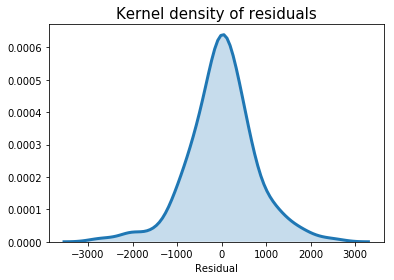

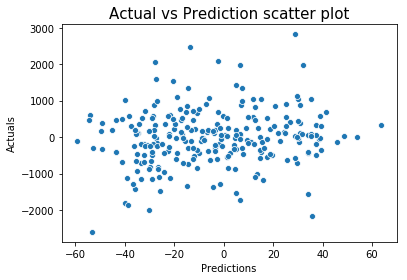

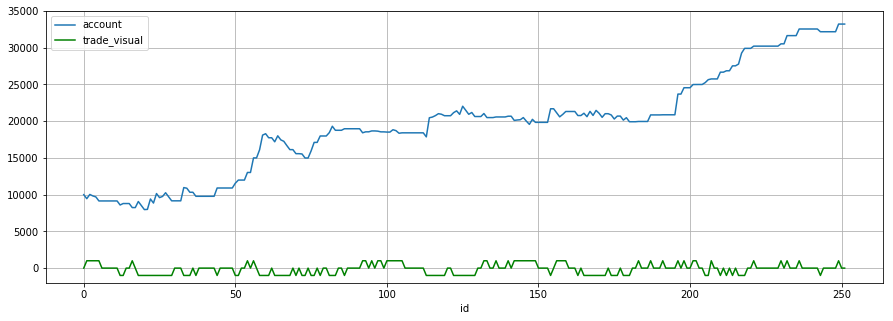

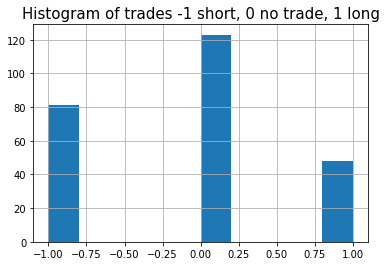

In [94]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=20)

In [95]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
# remove outliers
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1930 samples, validate on 483 samples
Epoch 1/1000
1930/1930 [==============================] - 2s 1ms/step - loss: 132248.6716 - val_loss: 131888.2894

Epoch 00001: val_loss improved from inf to 131888.28943, saving model to saved_models/weights.corn_reg.hdf5
Epoch 2/1000
1930/1930 [==============================] - 0s 148us/step - loss: 132247.8099 - val_loss: 131888.3345

Epoch 00002: val_loss did not improve from 131888.28943
Epoch 3/1000
1930/1930 [==============================] - 0s 138us/step - loss: 132244.2460 - val_loss: 131887.5413

Epoch 00003: val_loss improved from 131888.28943 to 131887.54129, saving model to saved_models/weights.corn_reg.hdf5
Epoch 4/1000
1930/1930 [==============================] - 0s 146us/step - loss: 132248.1692 - val_loss: 131886.2322

Epoch 00004: val_loss improved from 131887.54129 to 131886.23224, saving model to saved_models/weights.corn_reg.hdf5
Epoch 5/1000
1930/1930 [==============================] - 0s 150us/step - loss: 132236.44


Epoch 00039: val_loss did not improve from 131859.34760
Epoch 40/1000
1930/1930 [==============================] - 0s 149us/step - loss: 131417.4000 - val_loss: 131876.0909

Epoch 00040: val_loss did not improve from 131859.34760
Epoch 41/1000
1930/1930 [==============================] - 0s 136us/step - loss: 131353.9843 - val_loss: 131884.4589

Epoch 00041: val_loss did not improve from 131859.34760
Epoch 42/1000
1930/1930 [==============================] - 0s 141us/step - loss: 131379.0292 - val_loss: 131885.2308

Epoch 00042: val_loss did not improve from 131859.34760
Epoch 43/1000
1930/1930 [==============================] - 0s 139us/step - loss: 131241.7151 - val_loss: 131890.0576

Epoch 00043: val_loss did not improve from 131859.34760
Epoch 44/1000
1930/1930 [==============================] - 0s 145us/step - loss: 131159.8682 - val_loss: 131893.7050

Epoch 00044: val_loss did not improve from 131859.34760
Epoch 45/1000
1930/1930 [==============================] - 0s 139us/step 

1930/1930 [==============================] - 0s 139us/step - loss: 127860.8015 - val_loss: 132027.7349

Epoch 00087: val_loss did not improve from 131859.34760
Epoch 88/1000
1930/1930 [==============================] - 0s 142us/step - loss: 127724.4354 - val_loss: 132038.3455

Epoch 00088: val_loss did not improve from 131859.34760
Epoch 89/1000
1930/1930 [==============================] - 0s 154us/step - loss: 127667.6752 - val_loss: 132039.8753

Epoch 00089: val_loss did not improve from 131859.34760
Epoch 90/1000
1930/1930 [==============================] - 0s 153us/step - loss: 127509.2239 - val_loss: 132043.8110

Epoch 00090: val_loss did not improve from 131859.34760
Epoch 91/1000
1930/1930 [==============================] - 0s 138us/step - loss: 127430.1601 - val_loss: 132047.6207

Epoch 00091: val_loss did not improve from 131859.34760
Epoch 92/1000
1930/1930 [==============================] - 0s 144us/step - loss: 127298.4798 - val_loss: 132044.0364

Epoch 00092: val_loss did 

1930/1930 [==============================] - 0s 141us/step - loss: 122698.6284 - val_loss: 132187.3079

Epoch 00134: val_loss did not improve from 131859.34760
Epoch 135/1000
1930/1930 [==============================] - 0s 140us/step - loss: 122977.6057 - val_loss: 132195.0302

Epoch 00135: val_loss did not improve from 131859.34760
Epoch 136/1000
1930/1930 [==============================] - 0s 143us/step - loss: 122880.4653 - val_loss: 132208.7775

Epoch 00136: val_loss did not improve from 131859.34760
Epoch 137/1000
1930/1930 [==============================] - 0s 138us/step - loss: 122797.8240 - val_loss: 132216.1433

Epoch 00137: val_loss did not improve from 131859.34760
Epoch 138/1000
1930/1930 [==============================] - 0s 139us/step - loss: 122673.9429 - val_loss: 132220.8883

Epoch 00138: val_loss did not improve from 131859.34760
Epoch 139/1000
1930/1930 [==============================] - 0s 137us/step - loss: 122539.4875 - val_loss: 132218.5305

Epoch 00139: val_loss

1930/1930 [==============================] - 0s 140us/step - loss: 117670.3993 - val_loss: 132627.1191

Epoch 00181: val_loss did not improve from 131859.34760
Epoch 182/1000
1930/1930 [==============================] - 0s 143us/step - loss: 117353.5096 - val_loss: 132604.7927

Epoch 00182: val_loss did not improve from 131859.34760
Epoch 183/1000
1930/1930 [==============================] - 0s 146us/step - loss: 117425.0841 - val_loss: 132591.3951

Epoch 00183: val_loss did not improve from 131859.34760
Epoch 184/1000
1930/1930 [==============================] - 0s 143us/step - loss: 117177.7893 - val_loss: 132594.1695

Epoch 00184: val_loss did not improve from 131859.34760
Epoch 185/1000
1930/1930 [==============================] - 0s 139us/step - loss: 116975.8858 - val_loss: 132635.2840

Epoch 00185: val_loss did not improve from 131859.34760
Epoch 186/1000
1930/1930 [==============================] - 0s 145us/step - loss: 117070.7858 - val_loss: 132644.0301

Epoch 00186: val_loss

1930/1930 [==============================] - 0s 146us/step - loss: 111614.1385 - val_loss: 133692.4644

Epoch 00228: val_loss did not improve from 131859.34760
Epoch 229/1000
1930/1930 [==============================] - 0s 148us/step - loss: 111477.1999 - val_loss: 133749.1402

Epoch 00229: val_loss did not improve from 131859.34760
Epoch 230/1000
1930/1930 [==============================] - 0s 148us/step - loss: 111248.4551 - val_loss: 133727.6117

Epoch 00230: val_loss did not improve from 131859.34760
Epoch 231/1000
1930/1930 [==============================] - 0s 152us/step - loss: 111271.4400 - val_loss: 133825.2277

Epoch 00231: val_loss did not improve from 131859.34760
Epoch 232/1000
1930/1930 [==============================] - 0s 139us/step - loss: 110567.3977 - val_loss: 133890.3987

Epoch 00232: val_loss did not improve from 131859.34760
Epoch 233/1000
1930/1930 [==============================] - 0s 145us/step - loss: 110892.7789 - val_loss: 133926.6257

Epoch 00233: val_loss

1930/1930 [==============================] - 0s 142us/step - loss: 104288.7982 - val_loss: 134713.8284

Epoch 00275: val_loss did not improve from 131859.34760
Epoch 276/1000
1930/1930 [==============================] - 0s 145us/step - loss: 104111.3257 - val_loss: 134819.2431

Epoch 00276: val_loss did not improve from 131859.34760
Epoch 277/1000
1930/1930 [==============================] - 0s 145us/step - loss: 105096.2237 - val_loss: 134852.7812

Epoch 00277: val_loss did not improve from 131859.34760
Epoch 278/1000
1930/1930 [==============================] - 0s 135us/step - loss: 103414.9002 - val_loss: 134859.4125

Epoch 00278: val_loss did not improve from 131859.34760
Epoch 279/1000
1930/1930 [==============================] - 0s 139us/step - loss: 103679.7220 - val_loss: 134897.4938

Epoch 00279: val_loss did not improve from 131859.34760
Epoch 280/1000
1930/1930 [==============================] - 0s 136us/step - loss: 103511.4736 - val_loss: 134897.8581

Epoch 00280: val_loss

1930/1930 [==============================] - 0s 140us/step - loss: 96637.8050 - val_loss: 136118.3519

Epoch 00322: val_loss did not improve from 131859.34760
Epoch 323/1000
1930/1930 [==============================] - 0s 140us/step - loss: 96634.2101 - val_loss: 136197.0013

Epoch 00323: val_loss did not improve from 131859.34760
Epoch 324/1000
1930/1930 [==============================] - 0s 138us/step - loss: 97290.0341 - val_loss: 136230.1420

Epoch 00324: val_loss did not improve from 131859.34760
Epoch 325/1000
1930/1930 [==============================] - 0s 141us/step - loss: 96801.9108 - val_loss: 136174.8437

Epoch 00325: val_loss did not improve from 131859.34760
Epoch 326/1000
1930/1930 [==============================] - 0s 136us/step - loss: 96816.8443 - val_loss: 136379.2039

Epoch 00326: val_loss did not improve from 131859.34760
Epoch 327/1000
1930/1930 [==============================] - 0s 146us/step - loss: 96745.8994 - val_loss: 136347.7056

Epoch 00327: val_loss did n

1930/1930 [==============================] - 0s 160us/step - loss: 80401.9751 - val_loss: 140362.3420

Epoch 00416: val_loss did not improve from 131859.34760
Epoch 417/1000
1930/1930 [==============================] - 0s 160us/step - loss: 81306.9312 - val_loss: 140417.8635

Epoch 00417: val_loss did not improve from 131859.34760
Epoch 418/1000
1930/1930 [==============================] - 0s 159us/step - loss: 82528.4354 - val_loss: 140545.7515

Epoch 00418: val_loss did not improve from 131859.34760
Epoch 419/1000
1930/1930 [==============================] - 0s 154us/step - loss: 80676.7217 - val_loss: 140626.5268

Epoch 00419: val_loss did not improve from 131859.34760
Epoch 420/1000
1930/1930 [==============================] - 0s 152us/step - loss: 80199.4430 - val_loss: 140811.8864

Epoch 00420: val_loss did not improve from 131859.34760
Epoch 421/1000
1930/1930 [==============================] - 0s 150us/step - loss: 80580.9113 - val_loss: 140740.9043

Epoch 00421: val_loss did n

1930/1930 [==============================] - 0s 138us/step - loss: 66221.2831 - val_loss: 147056.9533

Epoch 00510: val_loss did not improve from 131859.34760
Epoch 511/1000
1930/1930 [==============================] - 0s 136us/step - loss: 66292.4992 - val_loss: 146986.6728

Epoch 00511: val_loss did not improve from 131859.34760
Epoch 512/1000
1930/1930 [==============================] - 0s 140us/step - loss: 67069.8452 - val_loss: 147227.9303

Epoch 00512: val_loss did not improve from 131859.34760
Epoch 513/1000
1930/1930 [==============================] - 0s 142us/step - loss: 66089.8148 - val_loss: 147450.6780

Epoch 00513: val_loss did not improve from 131859.34760
Epoch 514/1000
1930/1930 [==============================] - 0s 138us/step - loss: 65798.8552 - val_loss: 147241.7328

Epoch 00514: val_loss did not improve from 131859.34760
Epoch 515/1000
1930/1930 [==============================] - 0s 162us/step - loss: 66421.5600 - val_loss: 147600.5451

Epoch 00515: val_loss did n

1930/1930 [==============================] - 0s 142us/step - loss: 52608.7772 - val_loss: 156812.8001

Epoch 00604: val_loss did not improve from 131859.34760
Epoch 605/1000
1930/1930 [==============================] - 0s 165us/step - loss: 50821.3564 - val_loss: 157331.1240

Epoch 00605: val_loss did not improve from 131859.34760
Epoch 606/1000
1930/1930 [==============================] - 0s 146us/step - loss: 51968.0885 - val_loss: 157337.4760

Epoch 00606: val_loss did not improve from 131859.34760
Epoch 607/1000
1930/1930 [==============================] - 0s 146us/step - loss: 51797.3498 - val_loss: 157524.4985

Epoch 00607: val_loss did not improve from 131859.34760
Epoch 608/1000
1930/1930 [==============================] - 0s 145us/step - loss: 52287.9225 - val_loss: 157772.7369

Epoch 00608: val_loss did not improve from 131859.34760
Epoch 609/1000
1930/1930 [==============================] - 0s 142us/step - loss: 51655.7634 - val_loss: 158048.9975

Epoch 00609: val_loss did n

1930/1930 [==============================] - 0s 143us/step - loss: 39524.4332 - val_loss: 170398.6587

Epoch 00698: val_loss did not improve from 131859.34760
Epoch 699/1000
1930/1930 [==============================] - 0s 148us/step - loss: 38537.9044 - val_loss: 169985.1606

Epoch 00699: val_loss did not improve from 131859.34760
Epoch 700/1000
1930/1930 [==============================] - 0s 171us/step - loss: 39881.3113 - val_loss: 170193.8218

Epoch 00700: val_loss did not improve from 131859.34760
Epoch 701/1000
1930/1930 [==============================] - 0s 164us/step - loss: 40900.7148 - val_loss: 170272.0121

Epoch 00701: val_loss did not improve from 131859.34760
Epoch 702/1000
1930/1930 [==============================] - 0s 153us/step - loss: 38447.5246 - val_loss: 170688.9420

Epoch 00702: val_loss did not improve from 131859.34760
Epoch 703/1000
1930/1930 [==============================] - 0s 159us/step - loss: 38720.4136 - val_loss: 171414.9239

Epoch 00703: val_loss did n

1930/1930 [==============================] - 0s 135us/step - loss: 31206.0025 - val_loss: 184567.9711

Epoch 00792: val_loss did not improve from 131859.34760
Epoch 793/1000
1930/1930 [==============================] - 0s 143us/step - loss: 32603.2707 - val_loss: 185037.2830

Epoch 00793: val_loss did not improve from 131859.34760
Epoch 794/1000
1930/1930 [==============================] - 0s 137us/step - loss: 31874.1372 - val_loss: 185286.7616

Epoch 00794: val_loss did not improve from 131859.34760
Epoch 795/1000
1930/1930 [==============================] - 0s 136us/step - loss: 33168.7026 - val_loss: 186480.0253

Epoch 00795: val_loss did not improve from 131859.34760
Epoch 796/1000
1930/1930 [==============================] - 0s 140us/step - loss: 32755.9631 - val_loss: 187036.4448

Epoch 00796: val_loss did not improve from 131859.34760
Epoch 797/1000
1930/1930 [==============================] - 0s 143us/step - loss: 30829.9738 - val_loss: 186745.7672

Epoch 00797: val_loss did n

1930/1930 [==============================] - 0s 159us/step - loss: 25530.0798 - val_loss: 199195.4648

Epoch 00886: val_loss did not improve from 131859.34760
Epoch 887/1000
1930/1930 [==============================] - 0s 140us/step - loss: 25266.5560 - val_loss: 199167.5481

Epoch 00887: val_loss did not improve from 131859.34760
Epoch 888/1000
1930/1930 [==============================] - 0s 142us/step - loss: 26429.6060 - val_loss: 199613.8634

Epoch 00888: val_loss did not improve from 131859.34760
Epoch 889/1000
1930/1930 [==============================] - 0s 145us/step - loss: 25827.1057 - val_loss: 200403.7890

Epoch 00889: val_loss did not improve from 131859.34760
Epoch 890/1000
1930/1930 [==============================] - 0s 142us/step - loss: 25433.4655 - val_loss: 199786.7405

Epoch 00890: val_loss did not improve from 131859.34760
Epoch 891/1000
1930/1930 [==============================] - 0s 149us/step - loss: 24497.1675 - val_loss: 201031.0894

Epoch 00891: val_loss did n

1930/1930 [==============================] - 0s 143us/step - loss: 22758.2962 - val_loss: 214126.5181

Epoch 00980: val_loss did not improve from 131859.34760
Epoch 981/1000
1930/1930 [==============================] - 0s 135us/step - loss: 23770.6646 - val_loss: 213910.3755

Epoch 00981: val_loss did not improve from 131859.34760
Epoch 982/1000
1930/1930 [==============================] - 0s 140us/step - loss: 22127.1704 - val_loss: 214638.7999

Epoch 00982: val_loss did not improve from 131859.34760
Epoch 983/1000
1930/1930 [==============================] - 0s 139us/step - loss: 23184.8019 - val_loss: 213304.1145

Epoch 00983: val_loss did not improve from 131859.34760
Epoch 984/1000
1930/1930 [==============================] - 0s 139us/step - loss: 23771.3403 - val_loss: 212613.4517

Epoch 00984: val_loss did not improve from 131859.34760
Epoch 985/1000
1930/1930 [==============================] - 0s 137us/step - loss: 23252.4375 - val_loss: 210958.7007

Epoch 00985: val_loss did n

In [96]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

Predictions/Actual volatility correlation:  -0.02507405023701185
Returns  -73.87 %
Number of trades:  113
Number of short trades:  17
Number of long trades:  96
Earnings per trade:  -65.37
Earnings per short trade:  -31.93
Earnings per long trade:  -71.29


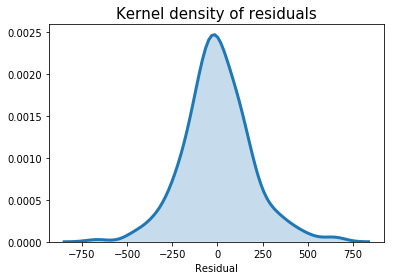

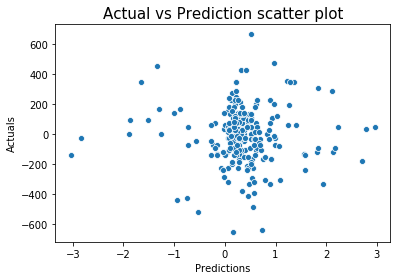

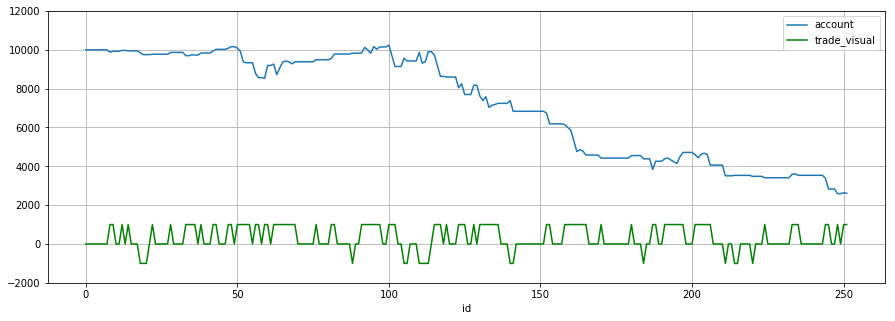

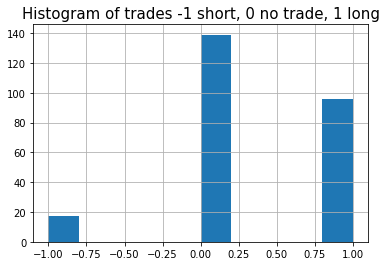

In [97]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.4)

In [98]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1922 samples, validate on 481 samples
Epoch 1/1000
1922/1922 [==============================] - 2s 1ms/step - loss: 133693.3916 - val_loss: 121255.1702

Epoch 00001: val_loss improved from inf to 121255.17015, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 2/1000
1922/1922 [==============================] - 0s 152us/step - loss: 133688.3378 - val_loss: 121255.2462

Epoch 00002: val_loss did not improve from 121255.17015
Epoch 3/1000
1922/1922 [==============================] - 0s 146us/step - loss: 133693.3142 - val_loss: 121255.7204

Epoch 00003: val_loss did not improve from 121255.17015
Epoch 4/1000
1922/1922 [==============================] - 0s 149us/step - loss: 133692.0993 - val_loss: 121255.8332

Epoch 00004: val_loss did not improve from 121255.17015
Epoch 5/1000
1922/1922 [==============================] - 0s 144us/step - loss: 133691.1076 - val_loss: 121256.6283

Epoch 00005: val_loss did not improve from 121255.17015
Epoch 6/1000
1922/1922 [============


Epoch 00047: val_loss did not improve from 121255.17015
Epoch 48/1000
1922/1922 [==============================] - 0s 147us/step - loss: 133121.7243 - val_loss: 121430.2070

Epoch 00048: val_loss did not improve from 121255.17015
Epoch 49/1000
1922/1922 [==============================] - 0s 145us/step - loss: 133114.8643 - val_loss: 121437.0101

Epoch 00049: val_loss did not improve from 121255.17015
Epoch 50/1000
1922/1922 [==============================] - 0s 206us/step - loss: 133070.0407 - val_loss: 121443.9196

Epoch 00050: val_loss did not improve from 121255.17015
Epoch 51/1000
1922/1922 [==============================] - 0s 169us/step - loss: 133034.4335 - val_loss: 121454.4066

Epoch 00051: val_loss did not improve from 121255.17015
Epoch 52/1000
1922/1922 [==============================] - 0s 137us/step - loss: 133000.9767 - val_loss: 121464.6219

Epoch 00052: val_loss did not improve from 121255.17015
Epoch 53/1000
1922/1922 [==============================] - 0s 166us/step 

1922/1922 [==============================] - 0s 145us/step - loss: 131063.1249 - val_loss: 121758.2691

Epoch 00095: val_loss did not improve from 121255.17015
Epoch 96/1000
1922/1922 [==============================] - 0s 140us/step - loss: 130912.5657 - val_loss: 121746.6958

Epoch 00096: val_loss did not improve from 121255.17015
Epoch 97/1000
1922/1922 [==============================] - 0s 147us/step - loss: 130905.4709 - val_loss: 121745.0833

Epoch 00097: val_loss did not improve from 121255.17015
Epoch 98/1000
1922/1922 [==============================] - 0s 155us/step - loss: 131050.1420 - val_loss: 121773.5660

Epoch 00098: val_loss did not improve from 121255.17015
Epoch 99/1000
1922/1922 [==============================] - 0s 156us/step - loss: 130797.6518 - val_loss: 121772.7877

Epoch 00099: val_loss did not improve from 121255.17015
Epoch 100/1000
1922/1922 [==============================] - 0s 146us/step - loss: 130653.5075 - val_loss: 121778.6157

Epoch 00100: val_loss did

1922/1922 [==============================] - 0s 151us/step - loss: 127721.4393 - val_loss: 122024.5760

Epoch 00142: val_loss did not improve from 121255.17015
Epoch 143/1000
1922/1922 [==============================] - 0s 161us/step - loss: 127730.2825 - val_loss: 122004.8657

Epoch 00143: val_loss did not improve from 121255.17015
Epoch 144/1000
1922/1922 [==============================] - 0s 141us/step - loss: 127294.4413 - val_loss: 122022.4004

Epoch 00144: val_loss did not improve from 121255.17015
Epoch 145/1000
1922/1922 [==============================] - 0s 142us/step - loss: 127223.4174 - val_loss: 122054.8227

Epoch 00145: val_loss did not improve from 121255.17015
Epoch 146/1000
1922/1922 [==============================] - 0s 144us/step - loss: 127367.0746 - val_loss: 122042.2682

Epoch 00146: val_loss did not improve from 121255.17015
Epoch 147/1000
1922/1922 [==============================] - 0s 142us/step - loss: 127164.0300 - val_loss: 122048.5968

Epoch 00147: val_loss

1922/1922 [==============================] - 0s 147us/step - loss: 122724.0572 - val_loss: 122501.2901

Epoch 00189: val_loss did not improve from 121255.17015
Epoch 190/1000
1922/1922 [==============================] - 0s 149us/step - loss: 122716.4863 - val_loss: 122519.2103

Epoch 00190: val_loss did not improve from 121255.17015
Epoch 191/1000
1922/1922 [==============================] - 0s 154us/step - loss: 123080.7280 - val_loss: 122521.0105

Epoch 00191: val_loss did not improve from 121255.17015
Epoch 192/1000
1922/1922 [==============================] - 0s 152us/step - loss: 123054.4120 - val_loss: 122516.5613

Epoch 00192: val_loss did not improve from 121255.17015
Epoch 193/1000
1922/1922 [==============================] - 0s 149us/step - loss: 122315.5900 - val_loss: 122489.6712

Epoch 00193: val_loss did not improve from 121255.17015
Epoch 194/1000
1922/1922 [==============================] - 0s 155us/step - loss: 122814.8932 - val_loss: 122608.9713

Epoch 00194: val_loss

1922/1922 [==============================] - 0s 156us/step - loss: 117509.8988 - val_loss: 122943.9927

Epoch 00236: val_loss did not improve from 121255.17015
Epoch 237/1000
1922/1922 [==============================] - 0s 158us/step - loss: 117500.9955 - val_loss: 122974.2372

Epoch 00237: val_loss did not improve from 121255.17015
Epoch 238/1000
1922/1922 [==============================] - 0s 153us/step - loss: 117449.6411 - val_loss: 122902.2444

Epoch 00238: val_loss did not improve from 121255.17015
Epoch 239/1000
1922/1922 [==============================] - 0s 146us/step - loss: 117167.8424 - val_loss: 122956.2288

Epoch 00239: val_loss did not improve from 121255.17015
Epoch 240/1000
1922/1922 [==============================] - 0s 147us/step - loss: 116784.9372 - val_loss: 122990.8896

Epoch 00240: val_loss did not improve from 121255.17015
Epoch 241/1000
1922/1922 [==============================] - 0s 145us/step - loss: 116942.3038 - val_loss: 123093.9582

Epoch 00241: val_loss

1922/1922 [==============================] - 0s 147us/step - loss: 111335.6688 - val_loss: 123668.4930

Epoch 00283: val_loss did not improve from 121255.17015
Epoch 284/1000
1922/1922 [==============================] - 0s 140us/step - loss: 111894.0404 - val_loss: 123723.6211

Epoch 00284: val_loss did not improve from 121255.17015
Epoch 285/1000
1922/1922 [==============================] - 0s 156us/step - loss: 111330.5079 - val_loss: 123786.0492

Epoch 00285: val_loss did not improve from 121255.17015
Epoch 286/1000
1922/1922 [==============================] - 0s 141us/step - loss: 110334.2279 - val_loss: 123797.5692

Epoch 00286: val_loss did not improve from 121255.17015
Epoch 287/1000
1922/1922 [==============================] - 0s 140us/step - loss: 110743.7382 - val_loss: 123845.8621

Epoch 00287: val_loss did not improve from 121255.17015
Epoch 288/1000
1922/1922 [==============================] - 0s 144us/step - loss: 111066.0890 - val_loss: 123775.7929

Epoch 00288: val_loss

1922/1922 [==============================] - 0s 140us/step - loss: 104103.6615 - val_loss: 125058.9278

Epoch 00330: val_loss did not improve from 121255.17015
Epoch 331/1000
1922/1922 [==============================] - 0s 159us/step - loss: 103413.1760 - val_loss: 125148.5004

Epoch 00331: val_loss did not improve from 121255.17015
Epoch 332/1000
1922/1922 [==============================] - 0s 145us/step - loss: 104349.0043 - val_loss: 125260.0203

Epoch 00332: val_loss did not improve from 121255.17015
Epoch 333/1000
1922/1922 [==============================] - 0s 147us/step - loss: 103798.2391 - val_loss: 125166.2496

Epoch 00333: val_loss did not improve from 121255.17015
Epoch 334/1000
1922/1922 [==============================] - 0s 146us/step - loss: 103453.7132 - val_loss: 125284.0979

Epoch 00334: val_loss did not improve from 121255.17015
Epoch 335/1000
1922/1922 [==============================] - 0s 142us/step - loss: 103826.7964 - val_loss: 125261.1848

Epoch 00335: val_loss

1922/1922 [==============================] - 0s 151us/step - loss: 97113.0731 - val_loss: 126494.2355

Epoch 00377: val_loss did not improve from 121255.17015
Epoch 378/1000
1922/1922 [==============================] - 0s 148us/step - loss: 97187.1335 - val_loss: 126465.8490

Epoch 00378: val_loss did not improve from 121255.17015
Epoch 379/1000
1922/1922 [==============================] - 0s 182us/step - loss: 97787.3134 - val_loss: 126562.0540

Epoch 00379: val_loss did not improve from 121255.17015
Epoch 380/1000
1922/1922 [==============================] - 0s 147us/step - loss: 96663.1261 - val_loss: 126546.9042

Epoch 00380: val_loss did not improve from 121255.17015
Epoch 381/1000
1922/1922 [==============================] - 0s 145us/step - loss: 96714.5890 - val_loss: 126346.7345

Epoch 00381: val_loss did not improve from 121255.17015
Epoch 382/1000
1922/1922 [==============================] - 0s 144us/step - loss: 95742.4925 - val_loss: 126412.9112

Epoch 00382: val_loss did n

1922/1922 [==============================] - 0s 169us/step - loss: 82073.2963 - val_loss: 130524.0922

Epoch 00471: val_loss did not improve from 121255.17015
Epoch 472/1000
1922/1922 [==============================] - 0s 143us/step - loss: 81373.7402 - val_loss: 130785.3571

Epoch 00472: val_loss did not improve from 121255.17015
Epoch 473/1000
1922/1922 [==============================] - 0s 145us/step - loss: 81165.2750 - val_loss: 130907.7527

Epoch 00473: val_loss did not improve from 121255.17015
Epoch 474/1000
1922/1922 [==============================] - 0s 137us/step - loss: 82603.3485 - val_loss: 130990.7883

Epoch 00474: val_loss did not improve from 121255.17015
Epoch 475/1000
1922/1922 [==============================] - 0s 144us/step - loss: 82600.4833 - val_loss: 131418.2080

Epoch 00475: val_loss did not improve from 121255.17015
Epoch 476/1000
1922/1922 [==============================] - 0s 148us/step - loss: 82334.8437 - val_loss: 131713.2655

Epoch 00476: val_loss did n

1922/1922 [==============================] - 0s 142us/step - loss: 67908.4244 - val_loss: 136939.4359

Epoch 00565: val_loss did not improve from 121255.17015
Epoch 566/1000
1922/1922 [==============================] - 0s 150us/step - loss: 67981.2715 - val_loss: 137355.7918

Epoch 00566: val_loss did not improve from 121255.17015
Epoch 567/1000
1922/1922 [==============================] - 0s 156us/step - loss: 69900.6071 - val_loss: 137526.5035

Epoch 00567: val_loss did not improve from 121255.17015
Epoch 568/1000
1922/1922 [==============================] - 0s 149us/step - loss: 68576.4392 - val_loss: 137139.2126

Epoch 00568: val_loss did not improve from 121255.17015
Epoch 569/1000
1922/1922 [==============================] - 0s 147us/step - loss: 67150.6742 - val_loss: 137121.0762

Epoch 00569: val_loss did not improve from 121255.17015
Epoch 570/1000
1922/1922 [==============================] - 0s 145us/step - loss: 65557.0179 - val_loss: 137268.2298

Epoch 00570: val_loss did n

1922/1922 [==============================] - 0s 145us/step - loss: 55232.2550 - val_loss: 143824.7895

Epoch 00659: val_loss did not improve from 121255.17015
Epoch 660/1000
1922/1922 [==============================] - 0s 151us/step - loss: 55432.2107 - val_loss: 144122.1596

Epoch 00660: val_loss did not improve from 121255.17015
Epoch 661/1000
1922/1922 [==============================] - 0s 148us/step - loss: 53518.4433 - val_loss: 144633.8083

Epoch 00661: val_loss did not improve from 121255.17015
Epoch 662/1000
1922/1922 [==============================] - 0s 149us/step - loss: 54115.9202 - val_loss: 144847.6779

Epoch 00662: val_loss did not improve from 121255.17015
Epoch 663/1000
1922/1922 [==============================] - 0s 147us/step - loss: 55064.2112 - val_loss: 145282.1871

Epoch 00663: val_loss did not improve from 121255.17015
Epoch 664/1000
1922/1922 [==============================] - 0s 148us/step - loss: 53740.9081 - val_loss: 145313.7608

Epoch 00664: val_loss did n

1922/1922 [==============================] - 0s 141us/step - loss: 43326.8089 - val_loss: 154080.9452

Epoch 00753: val_loss did not improve from 121255.17015
Epoch 754/1000
1922/1922 [==============================] - 0s 142us/step - loss: 43043.7391 - val_loss: 154029.3985

Epoch 00754: val_loss did not improve from 121255.17015
Epoch 755/1000
1922/1922 [==============================] - 0s 153us/step - loss: 41938.5779 - val_loss: 153185.8045

Epoch 00755: val_loss did not improve from 121255.17015
Epoch 756/1000
1922/1922 [==============================] - 0s 144us/step - loss: 42912.3643 - val_loss: 153779.0024

Epoch 00756: val_loss did not improve from 121255.17015
Epoch 757/1000
1922/1922 [==============================] - 0s 146us/step - loss: 45112.8035 - val_loss: 154199.6129

Epoch 00757: val_loss did not improve from 121255.17015
Epoch 758/1000
1922/1922 [==============================] - 0s 160us/step - loss: 44571.4604 - val_loss: 155441.8168

Epoch 00758: val_loss did n

1922/1922 [==============================] - 0s 150us/step - loss: 36674.1156 - val_loss: 167319.9628

Epoch 00847: val_loss did not improve from 121255.17015
Epoch 848/1000
1922/1922 [==============================] - 0s 161us/step - loss: 36568.2774 - val_loss: 167855.5335

Epoch 00848: val_loss did not improve from 121255.17015
Epoch 849/1000
1922/1922 [==============================] - 0s 148us/step - loss: 35838.3207 - val_loss: 167520.9941

Epoch 00849: val_loss did not improve from 121255.17015
Epoch 850/1000
1922/1922 [==============================] - 0s 154us/step - loss: 37444.7353 - val_loss: 167206.1407

Epoch 00850: val_loss did not improve from 121255.17015
Epoch 851/1000
1922/1922 [==============================] - 0s 147us/step - loss: 35318.1382 - val_loss: 167733.4360

Epoch 00851: val_loss did not improve from 121255.17015
Epoch 852/1000
1922/1922 [==============================] - 0s 154us/step - loss: 36582.9991 - val_loss: 167688.9471

Epoch 00852: val_loss did n

1922/1922 [==============================] - 0s 155us/step - loss: 35349.3984 - val_loss: 171958.5344

Epoch 00894: val_loss did not improve from 121255.17015
Epoch 895/1000
1922/1922 [==============================] - 0s 155us/step - loss: 32625.5050 - val_loss: 172702.9526

Epoch 00895: val_loss did not improve from 121255.17015
Epoch 896/1000
1922/1922 [==============================] - 0s 149us/step - loss: 34875.6075 - val_loss: 172571.2935

Epoch 00896: val_loss did not improve from 121255.17015
Epoch 897/1000
1922/1922 [==============================] - 0s 158us/step - loss: 33708.3850 - val_loss: 171940.2677

Epoch 00897: val_loss did not improve from 121255.17015
Epoch 898/1000
1922/1922 [==============================] - 0s 146us/step - loss: 34429.0882 - val_loss: 172607.6806

Epoch 00898: val_loss did not improve from 121255.17015
Epoch 899/1000
1922/1922 [==============================] - 0s 149us/step - loss: 35154.4179 - val_loss: 172745.6696

Epoch 00899: val_loss did n

1922/1922 [==============================] - 0s 152us/step - loss: 31845.5629 - val_loss: 181088.6333

Epoch 00988: val_loss did not improve from 121255.17015
Epoch 989/1000
1922/1922 [==============================] - 0s 143us/step - loss: 31318.8135 - val_loss: 181624.6708

Epoch 00989: val_loss did not improve from 121255.17015
Epoch 990/1000
1922/1922 [==============================] - 0s 143us/step - loss: 30426.2159 - val_loss: 180878.9383

Epoch 00990: val_loss did not improve from 121255.17015
Epoch 991/1000
1922/1922 [==============================] - 0s 145us/step - loss: 30781.0823 - val_loss: 181272.9840

Epoch 00991: val_loss did not improve from 121255.17015
Epoch 992/1000
1922/1922 [==============================] - 0s 145us/step - loss: 31254.2748 - val_loss: 182244.9717

Epoch 00992: val_loss did not improve from 121255.17015
Epoch 993/1000
1922/1922 [==============================] - 0s 145us/step - loss: 31504.9592 - val_loss: 182230.0071

Epoch 00993: val_loss did n

In [99]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

Predictions/Actual volatility correlation:  -0.020443528840394118
Returns  -12.92 %
Number of trades:  23
Number of short trades:  0
Number of long trades:  23
Earnings per trade:  -56.17
Earnings per short trade:  0.00
Earnings per long trade:  -56.17


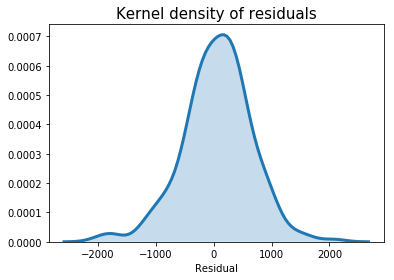

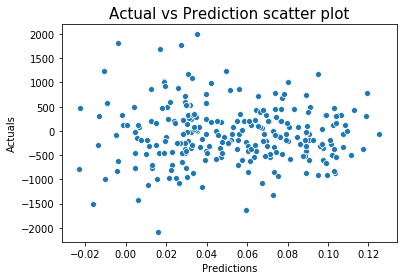

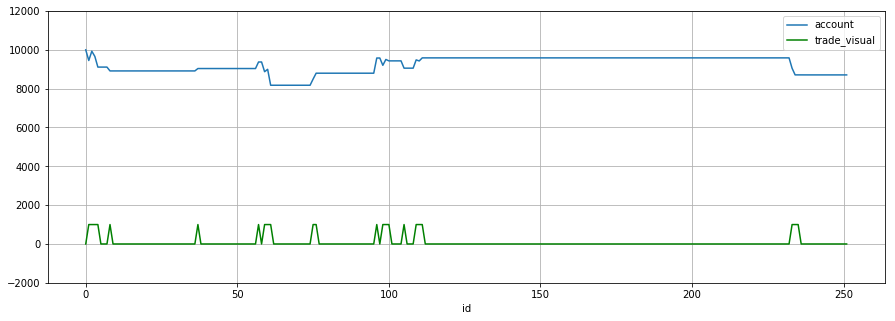

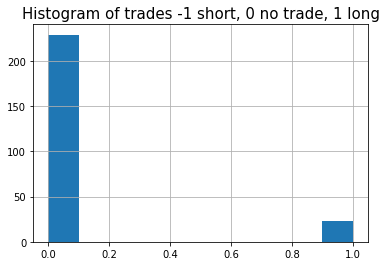

In [100]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=0.1)

# Conclusions
Only Gold regressor has data that returns positive results. Correlation between actual gold price and predictions is around $0.15$ (depending on training).

Corn and Coffee has rather random correlation with actual performance (also training is not going well).
Last weights update for keras neural network regressor (1000 epochs):

| Gold | Corn | Coffee |
|------|------|--------|
| 512  |   32 | 1      |

I am surprised that I cannot achieve better results with corn. Since corn retained most information by PCA transformation. I expected to have best training results with corn.

# H2O AutoML experiment

In [101]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16; OpenJDK Runtime Environment (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1); OpenJDK 64-Bit Server VM (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1, mixed mode, sharing)
  Starting server from /home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpkxv_1q8d
  JVM stdout: /tmp/tmpkxv_1q8d/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmpkxv_1q8d/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_martin_8m9ve1
H2O cluster total nodes:,1
H2O cluster free memory:,2.389 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


### Classification
Based on the H2O documentation only 2 categories are supported for AutoML. This model was generated for long trades.

In [102]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190207_080543_model_1,0.479587,0.607513,0.49148,0.456493,0.208386
XRT_1_AutoML_20190207_080543,0.477046,0.69162,0.5,0.476521,0.227073
StackedEnsemble_BestOfFamily_AutoML_20190207_080543,0.476126,0.60746,0.5,0.456459,0.208355
StackedEnsemble_AllModels_AutoML_20190207_080543,0.476126,0.60746,0.5,0.456459,0.208355
DRF_1_AutoML_20190207_080543,0.472127,0.650638,0.494616,0.474203,0.224868


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde3e51ee48>]],
      dtype=object)

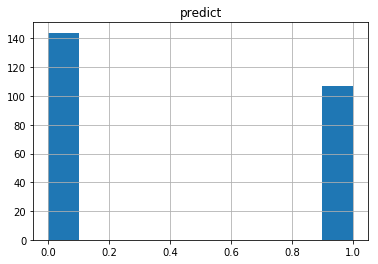

In [103]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  88.17 %
Number of trades:  107
Number of short trades:  0
Number of long trades:  107
Earnings per trade:  82.40
Earnings per short trade:  0.00
Earnings per long trade:  82.40


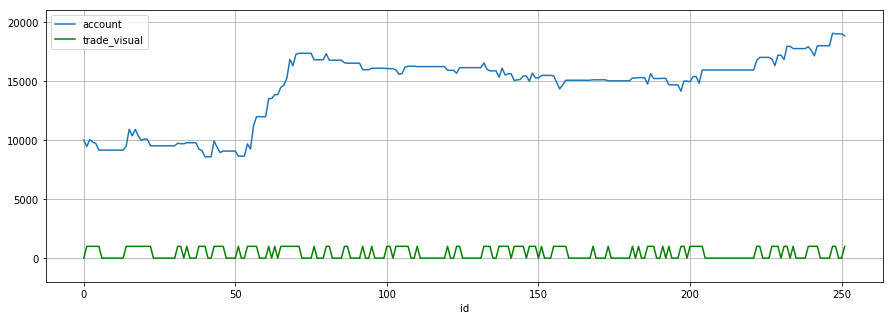

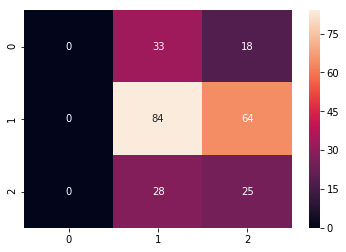

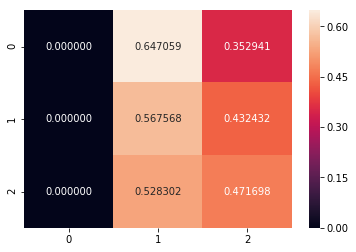

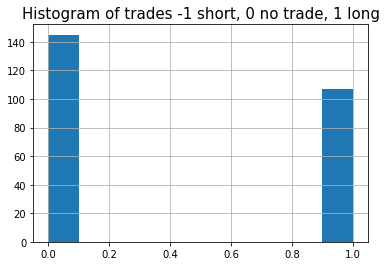

In [104]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

### H2O AutoML gold regressor

In [105]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
print(train.head())
x = train.columns
y = "label"
x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, max_runtime_secs=600, seed=1234, stopping_metric='deviance')
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
-331248,-27640.9,567537,65888,59525.3,252952,55627.9,-128754,107664,-216797,-88334.8,-158876,-132532,109755,-46152.6,-48243.4,102096,-26623.6,30557,96471.9,128856,-45498.6,7400.27,-52095.7,-102416,11413.4,193359,43174.8,2397.14,102818,51492,86161.9,36587.2,-431.163,-59398.9,-16408.3,-31970.8,7392.44,-41167.5,-38087.9,-79022.2,39880,74855.5,59099.8,-57810.6,4571.96,6865.5,69375.7,-24542.1,-2964.83,38010.9,50722.6,-49494,84525.8,-50325.3,1617.01,9757.53,40051,13361,28889.2,64254.2,-927.344,-13659.5,-973.585,57239.3,-14635.2,51039.1,-37447.1,71646.4,12300.9,7308.94,2995.98,66098,-25603.1,118375,-14342.2,23159.5,-106860,-30568.6,66324.5,-28319.3,-19414.8,74039.7,20878.1,-57363.5,-37656.5,15939.3,19836.3,52715.5,35991,40769.2,-14441.3,69806.5,36537.7,-44491.1,-57462,39878.1,25845.4,-8552.88,-6417.83,5903.48,-26696.2,6223.8,25249.4,16073.9,-3946.47,14822.4,-45238.9,-22718.6,-5387.21,63061.7,-21204.8,46718.1,-10246.8,-17679.4,82309.2,10278.2,33819.8,14791.7,-10318.9,38208.1,36031.4,-22415.4,-22948.7,9237.39,-46271.5,-16025.7,-32045.3,11528.7,-14694,-52873.6,65658.5,78371.1,-3786.76,15688.5,-13926,-47534.8,39424.6,-27202.7,-29934.4,-18343.1,20998.2,9208.38,-16001.3,43712.7,-4050.55,-25511,16382.3,-60760.7,3977.03,-19944.2,64013.7,-39727.3,-37917,-13036.8,52607.2,48494.9,38249.9,-88103.1,-40157.5,-36073.4,9875.56,42455.1,42717.8,-17228.2,-902.95,-28762.9,-41110.7,18957.3,-28820.2,15033.3,-17562.3,-8803.51,23882.9,37622.3,-16041.9,26617.1,15831.3,-1452.96,-24442.8,-13424.9,-17986.4,-54551.6,100337,-12982.5,-20857.6,-49309.7,-29425.2,9438.39,-31290.8,20001,74281.2,38789.7,34382.4,-2799.05,-39896.4,32486.2,74129.7,-38974.9,33943.5
-325632,-21861.3,570463,61896.1,12385.8,263138,67919.9,-122209,98093.1,-221691,-106287,-152934,-113510,123914,-42969.4,-38251.7,83308.7,-40120.2,40592,115483,118716,-59971.5,15404.1,-53785.8,-114764,16018.2,177401,-17123,17396.5,124792,34830.4,80182.2,61158.6,-37570.1,-29884.3,-1243.13,-41191.5,25931.6,198.042,-70567.6,2435.07,24739,104129,15369.9,-67739.2,-63275.3,41865.1,42055.7,458.742,-15286.7,3486.52,45515.7,-82916.5,55935.8,-75649.4,-26103.3,2369.58,42338.8,8161.88,64239.1,56469.8,14761.5,-45009.8,17551.6,24207.2,21459,97579.9,16854,104355,-10585.3,-15991.3,-10664.7,79435.3,1332.76,94045.8,-13272.3,40374.8,-26720.8,-46435.1,69752,-29560.7,-20420.7,15062.6,-49836.2,-69314.5,-75523.9,30552.3,30807.6,78707.6,20325.7,73373.8,-9184.14,23539.3,49531.5,-8248.75,-20231,7103.48,21536.8,-42549,12079.5,-10135.3,-38184.1,21524,40226.9,13054.8,38784.9,-46167.2,-17813.3,-19602,-25986.1,7817.18,-32128.9,-23314.1,-50007.2,-49561.8,26797.7,24791.3,78396.3,19204.7,21994.7,-62312.4,-39373.4,38829.6,10357.8,-792.608,163.776,17432.4,-69134,-45877.9,-39993.2,-11836,24834.9,29452.1,55929.8,39657.4,43875.6,31612.3,76769.7,14581.8,15596.5,36543.6,-14573.6,-387.628,23286.4,-29384.7,-7514.05,-19781.8,20652.3,2781.08,-13415.9,23300.7,46168.7,-48293.3,37659.9,68456.3,35566.7,-16892.2,-7713.68,7171.18,-13490.9,21885.4,29476.2,-18953.5,-19306.2,52039.9,-14114.8,-110200,-44815.4,-31763.5,15814.1,-13441.6,23622.1,30740.1,5327.42,45627.3,16424.6,34625.1,-8653.75,-18554,63492.4,28164.3,5081.91,1326.42,-41837,-30386,3184.34,-34923.6,-38657.6,-41088.3,-20688.8,-18062.2,5762.19,-46274.8,-456.058,-35580.8,-13500,-2665.41,15078.1,-39647.8,4789.56
-322972,-16385.8,56900


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_grid_1_AutoML_20190207_080708_model_1,1.68431e+06,1297.81,1.68431e+06,895.899,nan
StackedEnsemble_BestOfFamily_AutoML_20190207_080708,1.68533e+06,1298.2,1.68533e+06,896.418,nan
StackedEnsemble_AllModels_AutoML_20190207_080708,1.68533e+06,1298.2,1.68533e+06,896.418,nan
GBM_grid_1_AutoML_20190207_080708_model_9,1.6923e+06,1300.88,1.6923e+06,897.703,nan
GBM_grid_1_AutoML_20190207_080708_model_7,1.6926e+06,1301,1.6926e+06,898.466,nan
GBM_grid_1_AutoML_20190207_080708_model_6,1.69501e+06,1301.93,1.69501e+06,899.696,nan
GBM_grid_1_AutoML_20190207_080708_model_5,1.6984e+06,1303.23,1.6984e+06,898.45,nan
GBM_grid_1_AutoML_20190207_080708_model_1,1.72597e+06,1313.76,1.72597e+06,910.145,nan
GBM_grid_1_AutoML_20190207_080708_model_4,1.73897e+06,1318.7,1.73897e+06,911.332,nan
GBM_5_AutoML_20190207_080708,1.74291e+06,1320.19,1.74291e+06,920.143,nan


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde3e401d30>]],
      dtype=object)

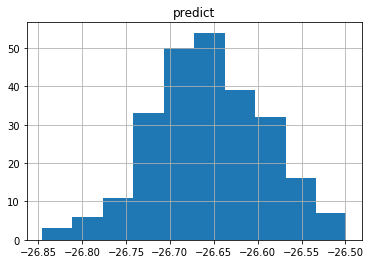

In [106]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [107]:
b

array([-26.64229968, -26.71641999, -26.708649  , -26.71515188,
       -26.63658053, -26.64446274, -26.64020086, -26.71253869,
       -26.66806547, -26.6756639 , -26.65211953, -26.64890615,
       -26.65344326, -26.61857664, -26.56154821, -26.57349536,
       -26.59273975, -26.64060133, -26.63128295, -26.66378233,
       -26.69216267, -26.72992689, -26.71783875, -26.6885868 ,
       -26.61967933, -26.58579422, -26.63610436, -26.69308651,
       -26.7082924 , -26.64246799, -26.54135393, -26.54918815,
       -26.64174458, -26.72843558, -26.78074026, -26.69889125,
       -26.73783544, -26.65964022, -26.65177147, -26.68606529,
       -26.67097812, -26.69366353, -26.6849714 , -26.6581517 ,
       -26.5768978 , -26.57849511, -26.66287907, -26.70672685,
       -26.70472282, -26.69631531, -26.64723116, -26.68017371,
       -26.64785677, -26.59564131, -26.63087327, -26.58388114,
       -26.62635637, -26.76022761, -26.7412088 , -26.68790975,
       -26.69833714, -26.70706475, -26.68660787, -26.66

In [108]:
def trade(x, treshold):
    ans = 0
    if abs(x) > treshold:
        if x > 0:
            ans = 1
        else:
            ans = -1
    return 0



preds = list(map(lambda x: trade(x, 200), b))

In [109]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Returns  0.00 %
Number of trades:  251
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00


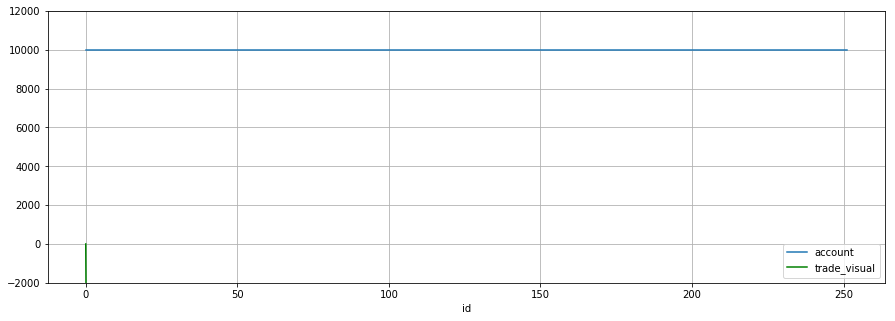

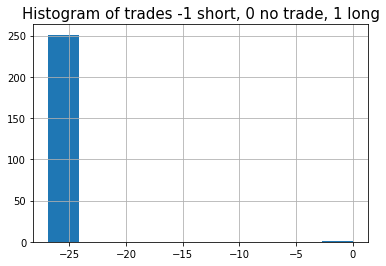

In [110]:
gold_account_reg = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True)

### H2O short trade

In [111]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_short_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_4_AutoML_20190207_081653,0.519649,0.652706,0.498539,0.472855,0.223592
GBM_grid_1_AutoML_20190207_081653_model_9,0.518424,1.12159,0.5,0.525174,0.275808
GBM_grid_1_AutoML_20190207_081653_model_7,0.517231,0.749949,0.5,0.498757,0.248758
DeepLearning_grid_1_AutoML_20190207_081653_model_1,0.515663,1.85899,0.5,0.581138,0.337721
GBM_1_AutoML_20190207_081653,0.514903,0.63345,0.499635,0.467266,0.218337
DRF_1_AutoML_20190207_081653,0.514799,0.644456,0.49188,0.470246,0.221131
GBM_grid_1_AutoML_20190207_081653_model_6,0.510856,0.603947,0.5,0.454695,0.206748
GBM_5_AutoML_20190207_081653,0.507968,0.616868,0.496502,0.460257,0.211836
GBM_grid_1_AutoML_20190207_081653_model_5,0.50742,0.604007,0.494704,0.454722,0.206772
GBM_3_AutoML_20190207_081653,0.503352,0.648492,0.495926,0.472189,0.222962


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde3e0b70b8>]],
      dtype=object)

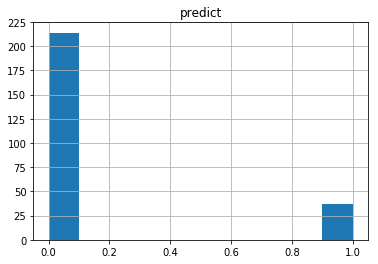

In [112]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = list(map(lambda x: -1 if x > 0 else 0, a.predict.values))
a.hist()

Returns  81.86 %
Number of trades:  37
Number of short trades:  37
Number of long trades:  0
Earnings per trade:  221.26
Earnings per short trade:  221.26
Earnings per long trade:  0.00


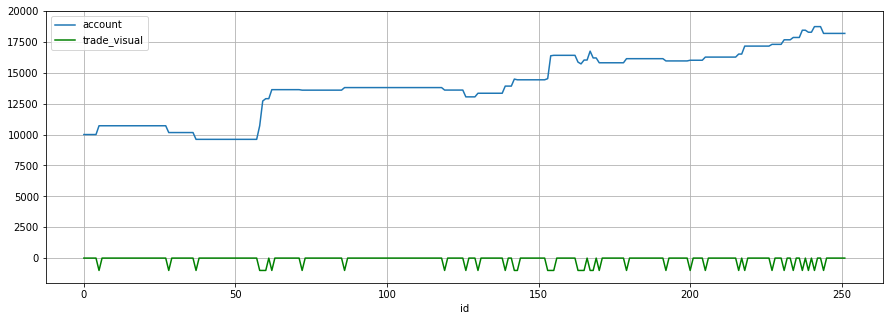

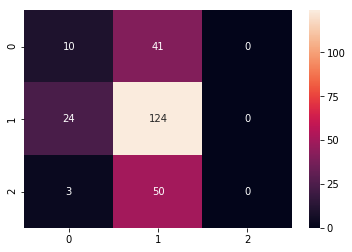

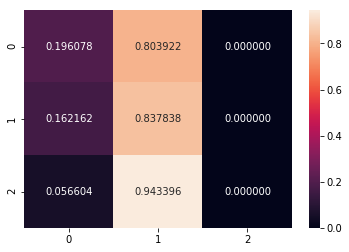

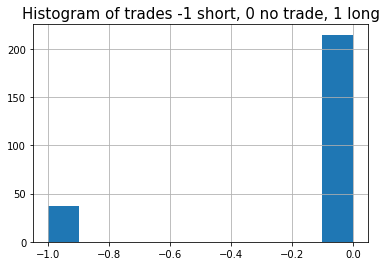

In [113]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [114]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_short_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190207_082701_model_3,0.542602,0.598815,0.473194,0.452171,0.204458
DeepLearning_grid_1_AutoML_20190207_082701_model_2,0.540511,1.16172,0.5,0.532601,0.283663
GBM_5_AutoML_20190207_082701,0.533986,0.608311,0.498179,0.456043,0.207975
GBM_grid_1_AutoML_20190207_082701_model_5,0.533266,0.599328,0.459379,0.452441,0.204703
GBM_1_AutoML_20190207_082701,0.530715,0.622389,0.487948,0.461382,0.212874
DRF_1_AutoML_20190207_082701,0.528342,0.660491,0.5,0.464089,0.215378
DeepLearning_grid_1_AutoML_20190207_082701_model_1,0.527023,1.79127,0.5,0.578255,0.334379
GBM_4_AutoML_20190207_082701,0.52617,0.641655,0.499272,0.465791,0.216961
GBM_3_AutoML_20190207_082701,0.525998,0.635475,0.499636,0.464675,0.215923
GBM_grid_1_AutoML_20190207_082701_model_1,0.525667,0.599714,0.487542,0.452573,0.204822


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde3e0b7a90>]],
      dtype=object)

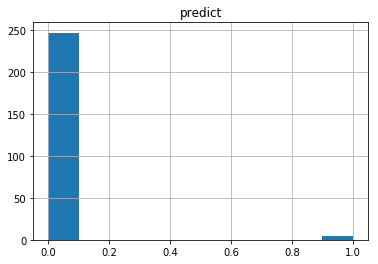

In [115]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

Returns  4.69 %
Number of trades:  4
Number of short trades:  4
Number of long trades:  0
Earnings per trade:  117.25
Earnings per short trade:  117.25
Earnings per long trade:  0.00


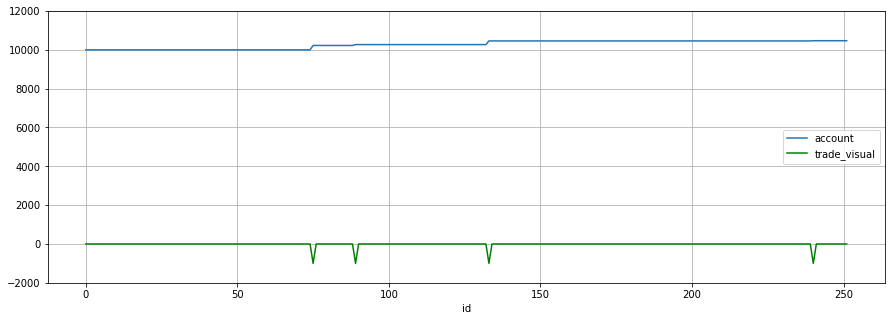

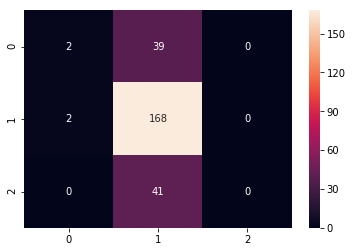

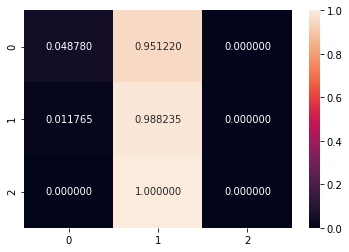

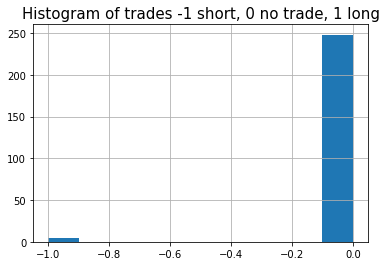

In [116]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [117]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_long_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190207_083628,0.545483,0.631149,0.486863,0.466671,0.217782
GBM_4_AutoML_20190207_083628,0.53766,0.651727,0.498509,0.47314,0.223861
StackedEnsemble_BestOfFamily_AutoML_20190207_083628,0.536519,0.613775,0.476989,0.459848,0.21146
GBM_5_AutoML_20190207_083628,0.532961,0.623489,0.499627,0.464026,0.21532
StackedEnsemble_AllModels_AutoML_20190207_083628,0.53005,0.614219,0.495399,0.460043,0.21164
DeepLearning_grid_1_AutoML_20190207_083628_model_1,0.529243,1.75996,0.474189,0.582765,0.339615
GBM_grid_1_AutoML_20190207_083628_model_5,0.528271,0.61419,0.473213,0.460061,0.211656
GBM_grid_1_AutoML_20190207_083628_model_3,0.525618,0.614071,0.475957,0.459999,0.211599
GBM_grid_1_AutoML_20190207_083628_model_1,0.523735,0.614736,0.499254,0.460275,0.211853
XRT_1_AutoML_20190207_083628,0.521799,0.642431,0.495296,0.47096,0.221803


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdda9374e48>]],
      dtype=object)

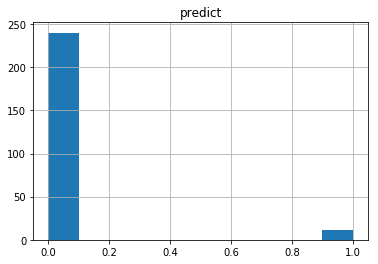

In [118]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  -8.05 %
Number of trades:  11
Number of short trades:  0
Number of long trades:  11
Earnings per trade:  -73.16
Earnings per short trade:  0.00
Earnings per long trade:  -73.16


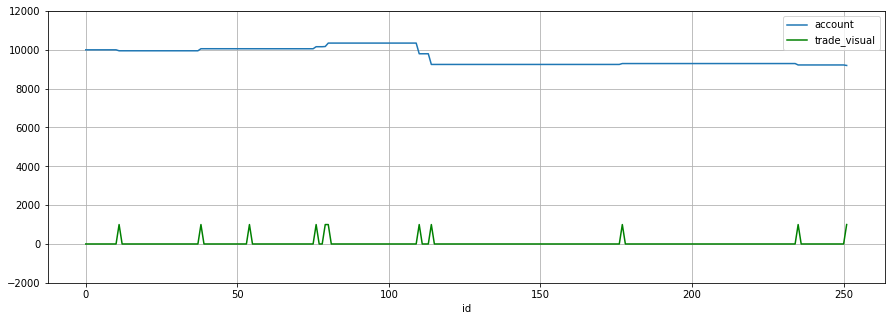

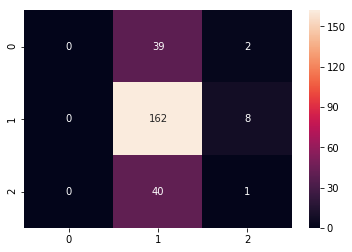

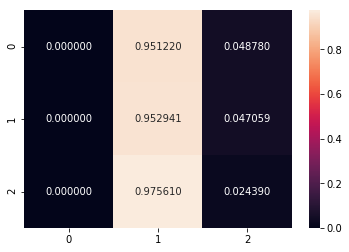

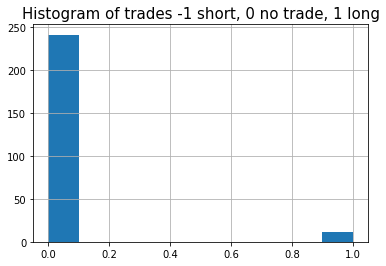

In [119]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [120]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190207_084557_model_1,0.527217,0.658517,0.5,0.482574,0.232877
DeepLearning_grid_1_AutoML_20190207_084557_model_2,0.526978,1.27952,0.5,0.582559,0.339375
DeepLearning_grid_1_AutoML_20190207_084557_model_1,0.520489,1.90309,0.5,0.611056,0.37339
GBM_5_AutoML_20190207_084557,0.519542,0.668057,0.493053,0.486933,0.237104
GBM_1_AutoML_20190207_084557,0.518702,0.686336,0.5,0.49393,0.243967
DeepLearning_1_AutoML_20190207_084557,0.515276,0.783688,0.497281,0.524022,0.274599
GBM_4_AutoML_20190207_084557,0.514719,0.703042,0.499587,0.500172,0.250172
DeepLearning_grid_1_AutoML_20190207_084557_model_3,0.513403,1.23501,0.5,0.581406,0.338033
GBM_2_AutoML_20190207_084557,0.510637,0.691967,0.499053,0.496575,0.246587
GBM_grid_1_AutoML_20190207_084557_model_2,0.509639,1.26803,0.491646,0.576808,0.332708


glm prediction progress: |████████████████████████████████████████████████| 100%
Returns  -100.27 %
Number of trades:  76
Number of short trades:  0
Number of long trades:  76
Earnings per trade:  -131.93
Earnings per short trade:  0.00
Earnings per long trade:  -131.93


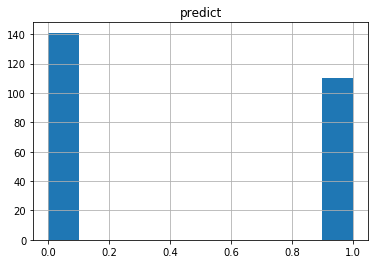

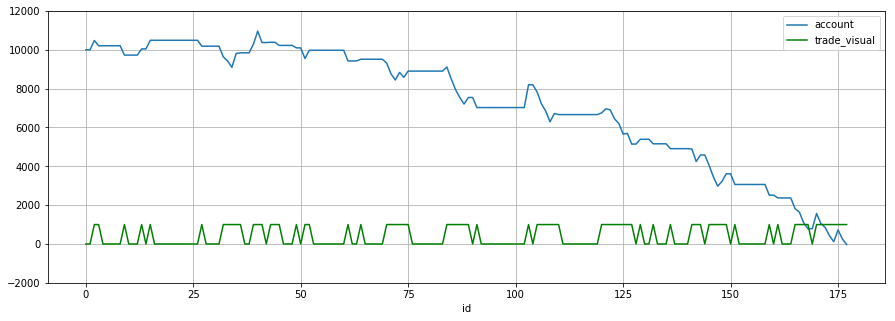

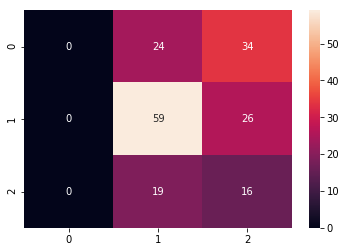

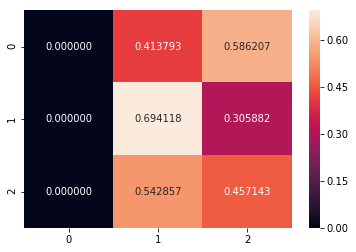

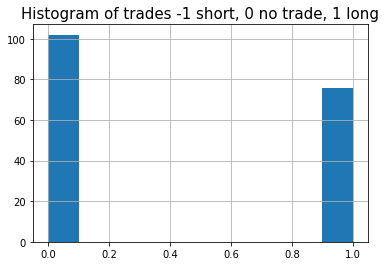

In [121]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [122]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_2_AutoML_20190207_085537,0.511064,0.698649,0.497471,0.500544,0.250544
DeepLearning_grid_1_AutoML_20190207_085537_model_1,0.508432,1.95652,0.5,0.620512,0.385035
GBM_4_AutoML_20190207_085537,0.506362,0.716539,0.5,0.506089,0.256126
DeepLearning_grid_1_AutoML_20190207_085537_model_3,0.504993,1.06442,0.5,0.571728,0.326873
GBM_3_AutoML_20190207_085537,0.502403,0.706331,0.5,0.502838,0.252846
GLM_grid_1_AutoML_20190207_085537_model_1,0.498935,0.666653,0.498733,0.486688,0.236866
XRT_1_AutoML_20190207_085537,0.498353,0.7057,0.498987,0.503283,0.253294
GBM_grid_1_AutoML_20190207_085537_model_2,0.497287,1.33192,0.5,0.5906,0.348809
StackedEnsemble_AllModels_AutoML_20190207_085537,0.497095,0.666139,0.5,0.486434,0.236618
DRF_1_AutoML_20190207_085537,0.496928,0.706637,0.498733,0.503576,0.253589


gbm prediction progress: |████████████████████████████████████████████████| 100%
Returns  203.93 %
Number of trades:  250
Number of short trades:  250
Number of long trades:  0
Earnings per trade:  81.57
Earnings per short trade:  81.57
Earnings per long trade:  0.00


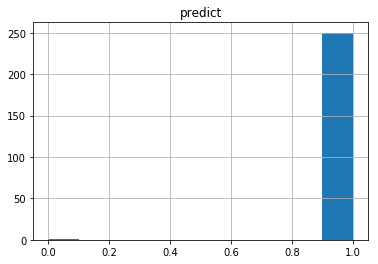

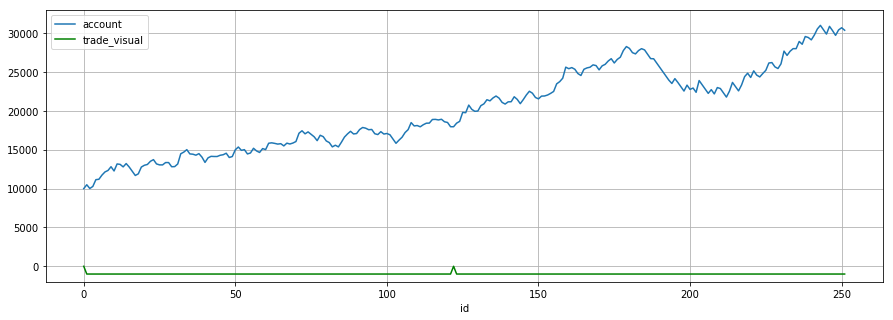

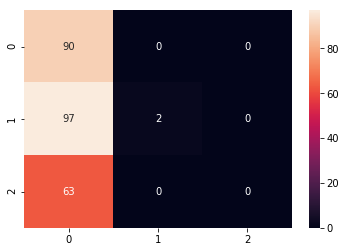

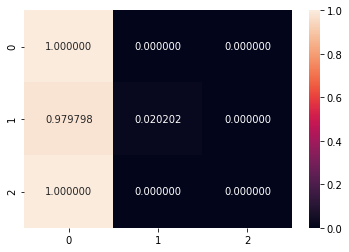

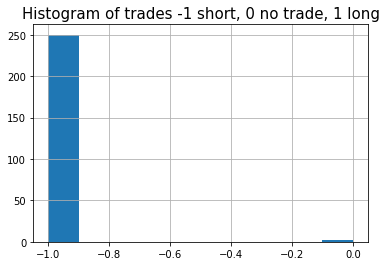

In [123]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

# H2O AutoML conclusion

AutoML regression results were very disappointing since all the predictions for gold were around -26 (which is mean value of training data). Classifiers seems to work better. I think you could get some information but overall I think it is necessary to get insight into the data.

In [124]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

# Comparison of performances

Below we will look at the comparison of the best trading strategy for each commodity versus mean reversal strategy and Nasdaq.

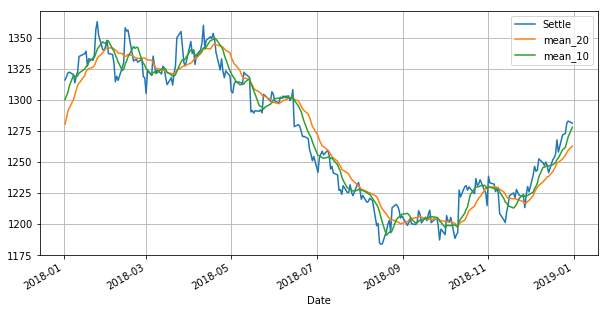

In [136]:
gold = mean_calculation(gold, 20, 10)
gold[['Settle', 'mean_20', 'mean_10']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)

In [137]:
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]

In [138]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [139]:
nasdaq_amount

1.5349783184312522

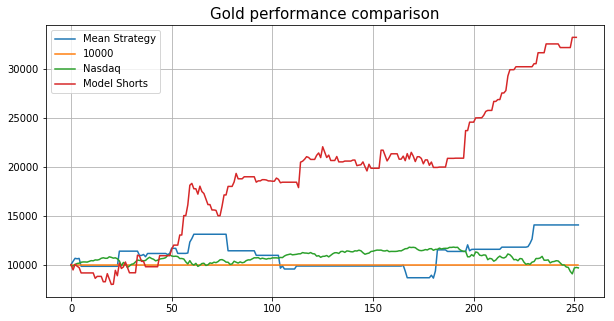

In [149]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

# gold_account_nn = get_performance(gold_clf_reg_nn
ax = pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               gold_account_nn.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
               ], axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Gold performance comparison', size=15)

In [141]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9894.853985
1,10332.5,10000,9837.292298
2,10636.5,10000,10000.000000
3,10589.0,10000,10107.064738
4,10627.0,10000,10136.229326


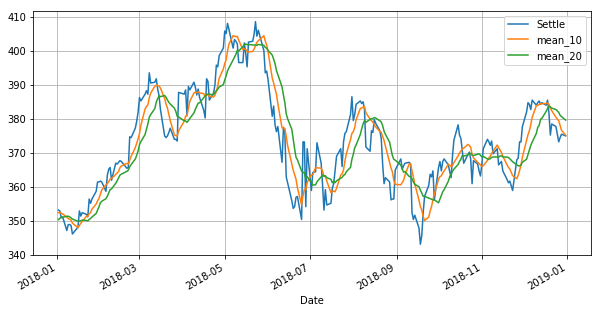

In [142]:
corn = mean_calculation(corn, 20, 10)
corn[['Settle', 'mean_10', 'mean_20']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

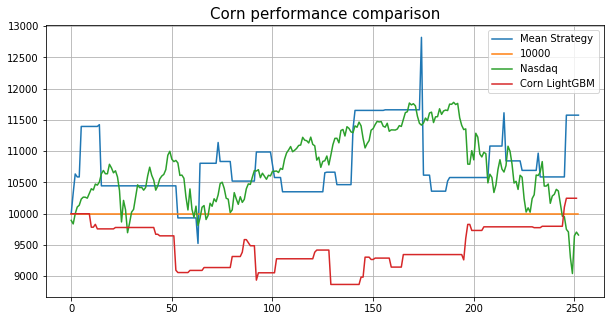

In [148]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               corn_account_lgb.rename(columns={'account': 'Corn LightGBM'})[['Corn LightGBM']]], 
               axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Corn performance comparison', size=15)

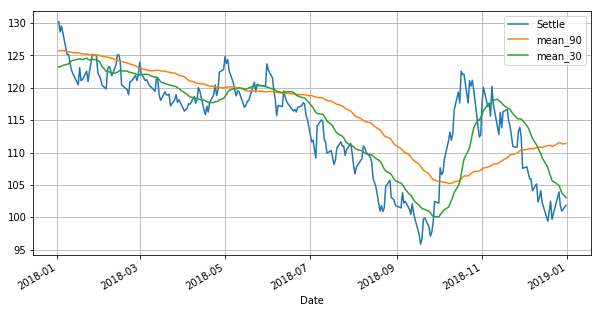

In [133]:
coffee = mean_calculation(coffee, 20, 10)
coffee[['Settle', 'mean_20', 'mean_10']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

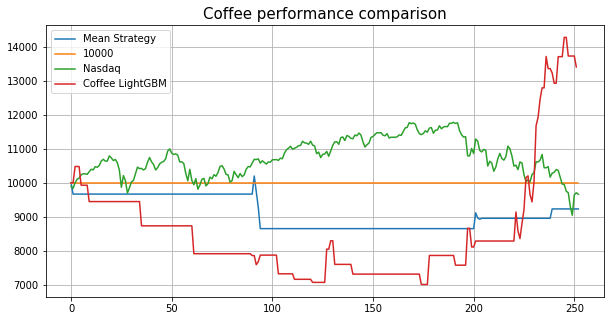

In [150]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                coffee_account_lgb.rename(columns={'account': 'Coffee LightGBM'})[['Coffee LightGBM']],
               ], axis=1).plot(figsize=(10,5), grid=True)
title = ax.set_title('Coffee performance comparison', size=15)

# Conclusion

Trading is a difficult ML problem. Out of three compared commodities gold, corn and coffee we were able to predict performance with gold. Other commodities behaved randomly with approximately 0 correlation to the actual volatility.

In the beginning of project, I was thinking of a classifier (short, no trade, long) because it is closer to the usage of model. I tested regressor as well. Regressor works better because there is more information. I tried different loss function when training regressor. I decided to use weighted MSE. This could be further modified for better function omitting errors below threshold.

Gold trading is the most capital intensive with very big stop losses (1000 long, 800 short). This can be problem for trading with $10 000\$$ account.

In case of corn and coffee the data was almost impossible to classify. I suspect more data transformation is needed to get better results.